In [88]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

from botorch.optim import optimize_acqf_discrete
from copy import deepcopy

cwd = os.getcwd()
sys.path.append("/".join(cwd.split("/")[:-2]))

from src.bax.alg.algorithms import TopK
from src.acquisition_functions.posterior_sampling import gen_posterior_sampling_batch
from src.acquisition_functions.bax_acquisition import BAXAcquisitionFunction
from src.fit_model import fit_model
# from src.performance_metrics import evaluate_performance
from src.utils import (
    generate_initial_data,
    generate_random_points,
    get_obj_vals,
    seed_torch,
    optimize_acqf_and_get_suggested_batch,
    get_function_samples,
)
from src.performance_metrics import output_dist_fn_norm, output_dist_fn_jaccard

In [89]:
def create_mesh(xmin, xmax, steps=20):
    length = xmax - xmin
    # xlim = [xmin - 0.05 * length, xmax + 0.05 * length]
    # ax = torch.linspace(xlim[0], xlim[1], steps)
    ax = torch.linspace(xmin + 0.05 * length, xmax - 0.05 * length, steps)
    xx = torch.meshgrid(ax, ax, indexing="ij")
    return xx

def reshape_mesh(xx):
    x1 = xx[0].reshape(-1)
    x2 = xx[1].reshape(-1)
    return torch.stack([x1, x2], dim=1)

def himmelblau(X, minimize=False):
    a = X[:, 0]
    b = X[:, 1]
    result = (a ** 2 + b - 11) ** 2 + (a + b ** 2 - 7) ** 2
    if not minimize:
        return -result
    else:
        return result
    
def obj_func(X, domain=[-6, 6]):
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X)
    # rescale X from 0, 1 to domain
    X_rescaled = X.clone()
    X_rescaled = (domain[1] - domain[0]) * X_rescaled + domain[0]
    f_0 = himmelblau
    return f_0(X_rescaled)

def evaluate_performance(model, algo, output_gt):
    '''
    Args:
        metrics: list of PerformanceMetric
        model: GP model
    '''
    posterior_mean_func = lambda x : model.posterior(x).mean
    _, output_mf = algo.run_algorithm_on_f(posterior_mean_func)
    performance_metrics = [
        output_dist_fn_jaccard(output_mf, output_gt),
        output_dist_fn_norm(output_mf, output_gt),
    ]
    return performance_metrics, output_mf


In [95]:
num_init_points = 6
input_dim = 2
seed = 0
k = 4
domain = [-6, 6]
max_iter = 41
batch_size = 1
kwargs = {}
seed_torch(seed)


In [96]:
x_mesh = create_mesh(0, 1, steps=10)
x_np = reshape_mesh(x_mesh).numpy()
optima = np.array(
    [
        [3, 2],
        [-2.805118, 3.131312],
        [-3.779310, -3.283186],
        [3.584458, -1.848126],
    ]
)
rescaled_optima = (optima - domain[0]) / 12
x_np = np.concatenate([x_np, rescaled_optima], axis=0)
x_path = [list(x) for x in x_np]

algo = TopK({"x_path": x_path, "k": k}, verbose=False)

y_np = obj_func(x_np)
x_top_k = x_np[y_np.argsort()[-k:]]

algo_gt = algo.get_copy()
_, output_gt = algo_gt.run_algorithm_on_f(obj_func)

inputs, obj_vals = generate_initial_data(
    num_init_points=num_init_points,
    input_dim=input_dim,
    obj_func=obj_func,
    seed=seed,
    **kwargs,
)

model = fit_model(
    inputs,
    obj_vals,
    model_type="gp",
    **kwargs
)

policies = ["ps", "bax"]
x_gp = {
    "ps" : inputs,
    "bax": inputs,
}
y_gp = {
    "ps" : obj_vals,
    "bax": obj_vals,
}
models = {
    "ps": deepcopy(model),
    "bax": deepcopy(model),
}

performance, output = evaluate_performance(model, algo.get_copy(), output_gt, **kwargs)
performances = {
    "ps": [performance],
    "bax": [performance],
}
_, output_mf = algo.run_algorithm_on_f(lambda x: model.posterior(x).mean)
outputs = {
    "ps": np.array(output_mf.x),
    "bax": np.array(output_mf.x)
}



In [97]:
policies = ["ps", "bax"]
n_samp = 30
iter_mcvals = {}
acq_vals = []

for t in range(max_iter):
    for policy in policies:
        algo_samp = algo.get_copy()
        mc_values = {}
        for x in x_np:
            mc_values[tuple(x)] = 0
        for n in range(n_samp):
            obj_func_sample = get_function_samples(models[policy])
            x_output = algo_samp.execute(obj_func_sample)
            mc_vals = iter_mcvals.get(t, mc_values)
            for x in x_output:
                mc_vals[tuple(x)] += 1
        iter_mcvals[t] = mc_vals

        algo_copy = algo.get_copy()
        if policy == "ps":
            x_next = gen_posterior_sampling_batch(models[policy], algo_copy, batch_size)
        elif policy == "bax":
            acq_func = BAXAcquisitionFunction(
                model=model, 
                algo=algo_copy,
                **kwargs, 
            )
            acq_func.initialize()
            acq_vals.append(acq_func(torch.from_numpy(x_np).unsqueeze(1)).detach().numpy())
            x_next, _ = optimize_acqf_discrete(acq_function=acq_func, q=batch_size, choices=torch.from_numpy(x_np), max_batch_size=100)
            
        y_next = obj_func(x_next)
        x_gp[policy] = torch.cat([x_gp[policy], x_next], dim=0)
        y_gp[policy] = torch.cat([y_gp[policy], y_next], dim=0)
        models[policy] = fit_model(
            x_gp[policy], 
            y_gp[policy], 
            model_type="gp", 
            **kwargs
        )
        performance, output = evaluate_performance(models[policy], algo.get_copy(), output_gt, **kwargs)
        performances[policy].append(performance)
        outputs[policy] = np.concatenate((outputs[policy], np.array(output.x)), axis=0)

        print(f"Policy: {policy}, Iter: {t}, Performance: {performances[policy][-1]} \n")

Policy: ps, Iter: 0, Performance: [1.0, 0.6407994544989399] 

Policy: bax, Iter: 0, Performance: [0.8571428571428572, 0.9485510024765113] 

Policy: ps, Iter: 1, Performance: [1.0, 0.5768985822650913] 

Policy: bax, Iter: 1, Performance: [1.0, 0.5399093512366734] 

Policy: ps, Iter: 2, Performance: [1.0, 0.5297390309257369] 

Policy: bax, Iter: 2, Performance: [0.8571428571428572, 0.5027153346031872] 

Policy: ps, Iter: 3, Performance: [1.0, 0.6185082383332812] 

Policy: bax, Iter: 3, Performance: [0.8571428571428572, 0.5027153346031872] 

Policy: ps, Iter: 4, Performance: [1.0, 0.5613231459858681] 

Policy: bax, Iter: 4, Performance: [0.8571428571428572, 0.23003559564934725] 

Policy: ps, Iter: 5, Performance: [1.0, 0.5613231459858681] 

Policy: bax, Iter: 5, Performance: [0.8571428571428572, 0.23003559564934725] 

Policy: ps, Iter: 6, Performance: [1.0, 0.5338519216219719] 

Policy: bax, Iter: 6, Performance: [0.8571428571428572, 0.1967172360670541] 

Policy: ps, Iter: 7, Performance:

In [98]:
mc_arrs = {}
for i in range(max_iter):
    arr = np.array([iter_mcvals[i][tuple(x)] for x in x_np])
    mc_arrs[i] = arr[:-4].reshape(10, 10)

In [99]:
for i in range(len(acq_vals)):
    acq_vals[i] = acq_vals[i][:100].reshape(10, 10)
    

In [100]:
PATH_ps = f"{os.getcwd()}/demo/ps_mc"
os.makedirs(PATH_ps, exist_ok=True)

PATH_bax = f"{os.getcwd()}/demo/eig"
os.makedirs(PATH_bax, exist_ok=True)

In [101]:
def plot(policy, path):
    fig, ax = plt.subplots(figsize=(8, 8))
    if policy == "ps":

        ax.contourf(x_mesh[0], x_mesh[1], mc_arrs[i], levels=20, cmap="Blues")
    elif policy == "bax":
        ax.contourf(x_mesh[0], x_mesh[1], acq_vals[i], cmap="Blues")
    color = {
        "ps" : 'b',
        "bax" : 'g'
    }
    ax.scatter(
        x_top_k[:, 0], 
        x_top_k[:, 1], 
        c="red", 
        marker="*",
        s=300,
        label="Top k",
    )
    ax.scatter(
        x_np[:, 0],
        x_np[:, 1],
        c="#6B3E26",
        marker=".",
        s=5,
        alpha=0.5,
        label="Discrete Set",
    )
    
    ax.scatter(
        x_gp[policy][:i + num_init_points, 0], 
        x_gp[policy][:i + num_init_points, 1], 
        c = color[policy],
        marker="o",
        alpha = 0.2,
        s=100,
        label="Sampled",
    )
    ax.scatter(
        outputs[policy][(i + 1) * k:(i + 2) * k, 0], 
        outputs[policy][(i + 1) * k:(i + 2) * k, 1], 
        c= "#ff7f0e",
        marker="P",
        s = 100,
        label="Algorithm Output",
    )
    
    ax.set_title(f"Iteration {i}")
    ax.set_xlim([0.1, 0.9])
    ax.set_ylim([0.1, 0.9])
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=4)
    plt.tight_layout()
    plt.savefig(
        f"{path}/{i}.pdf",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

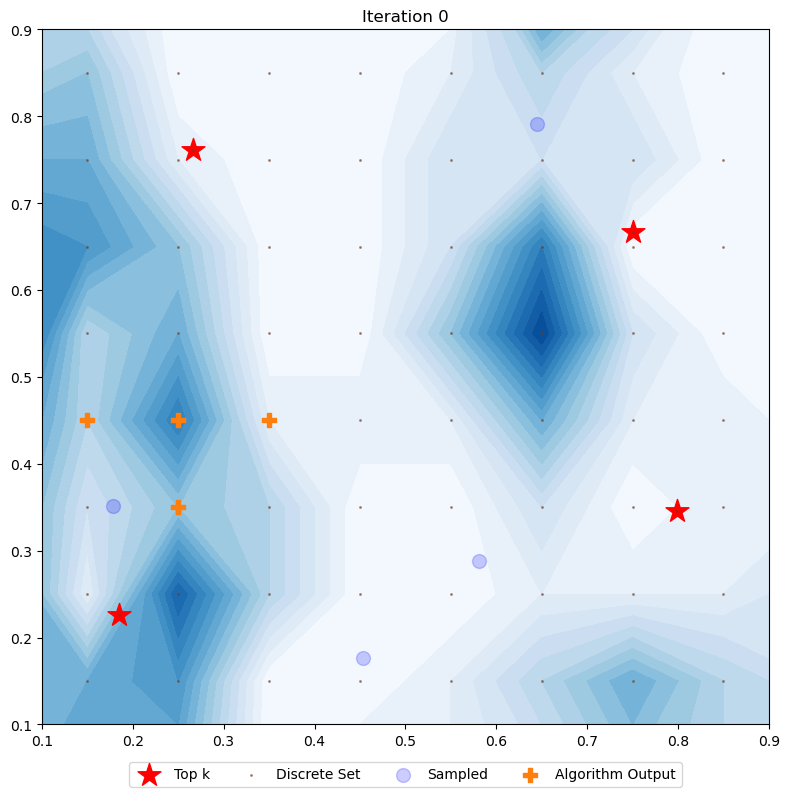

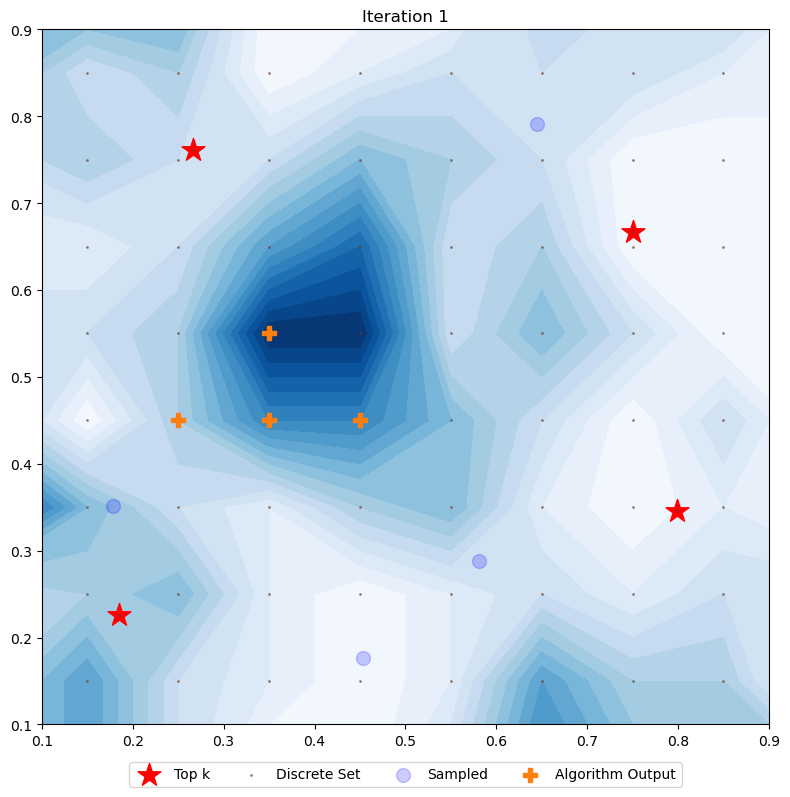

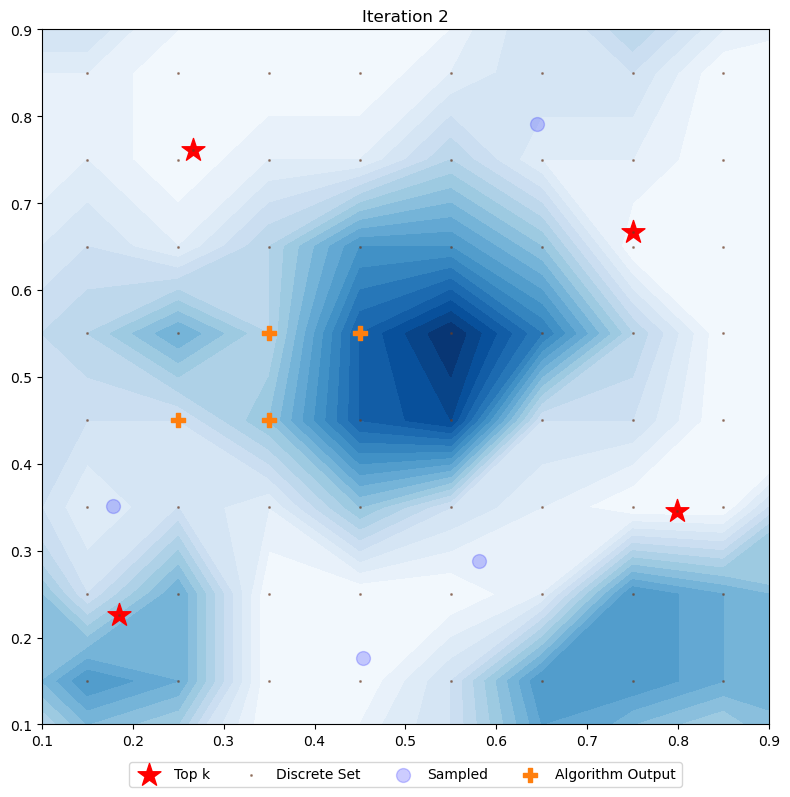

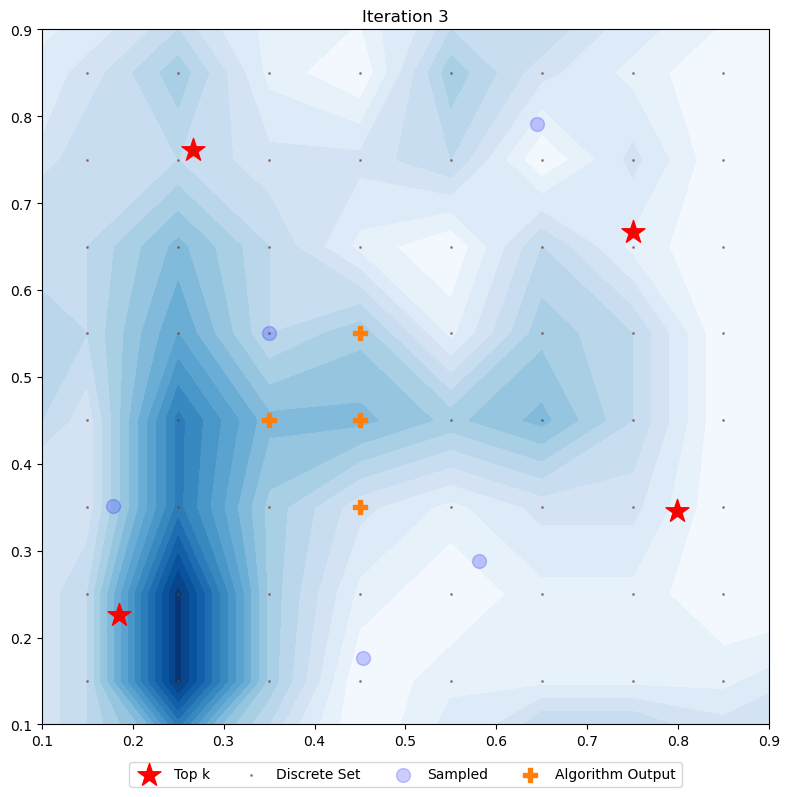

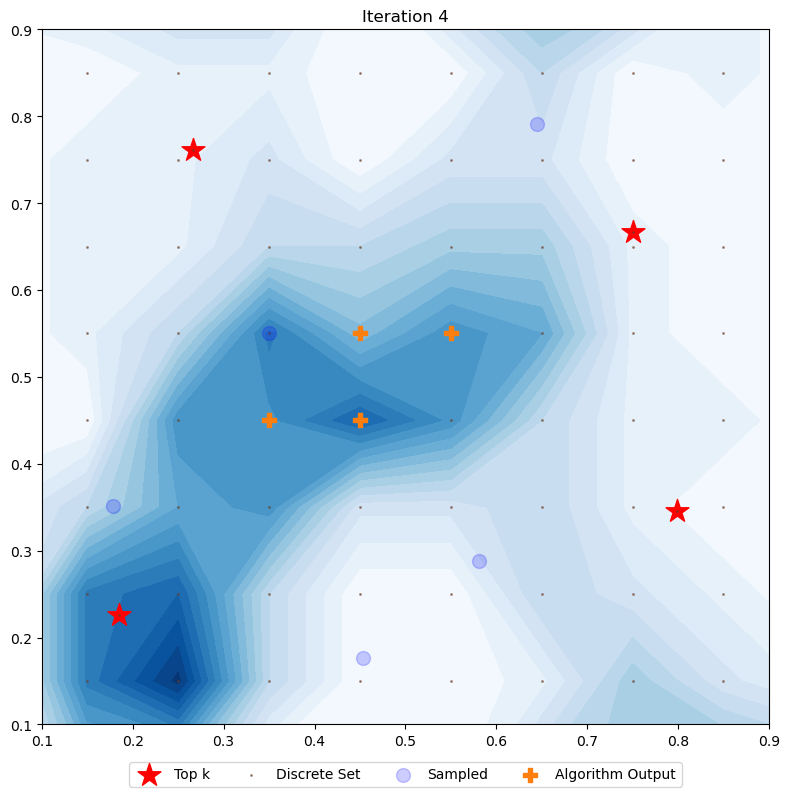

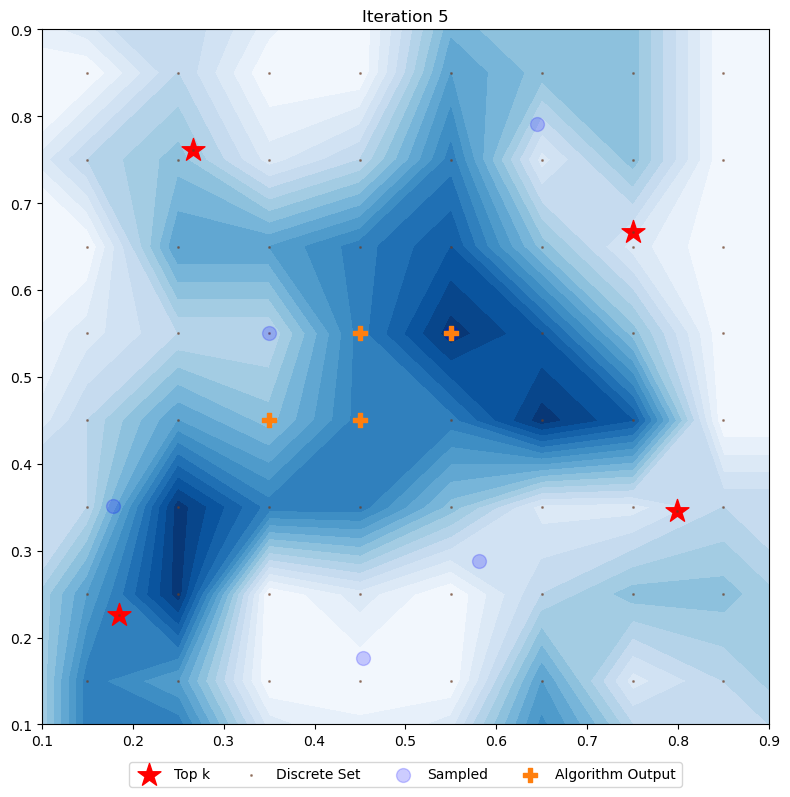

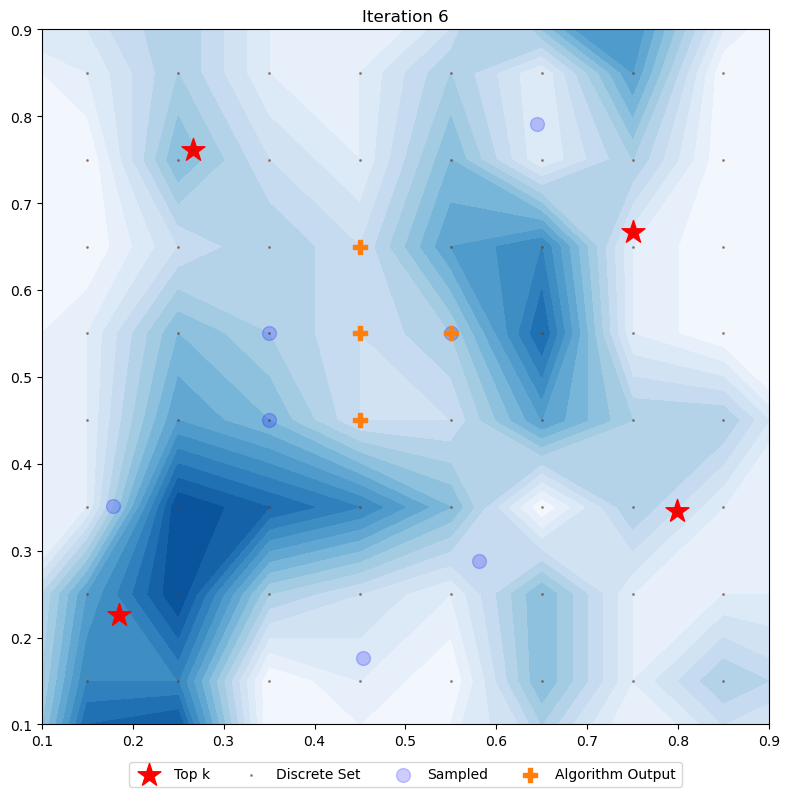

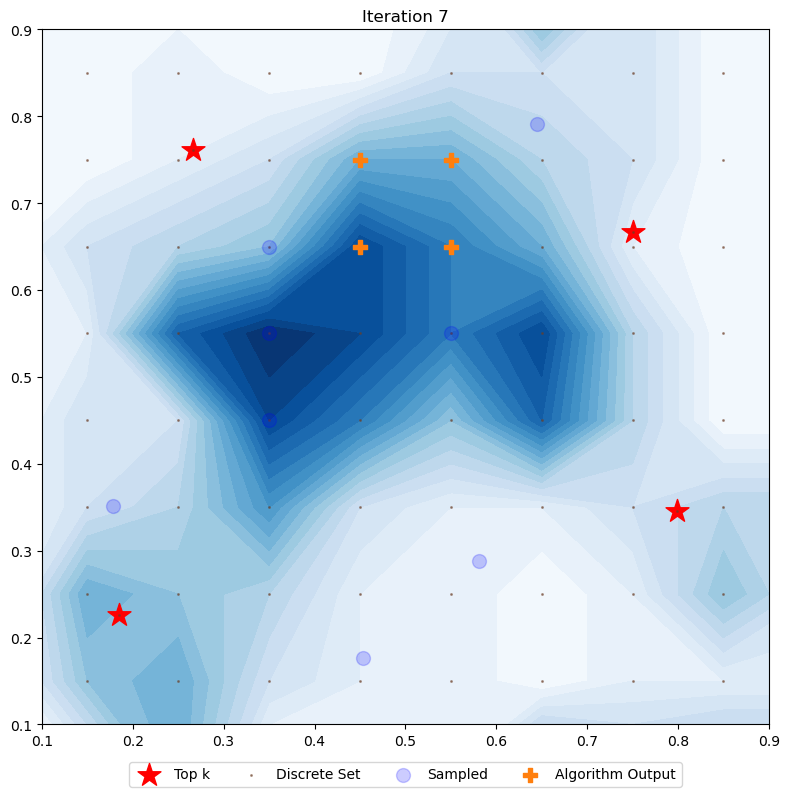

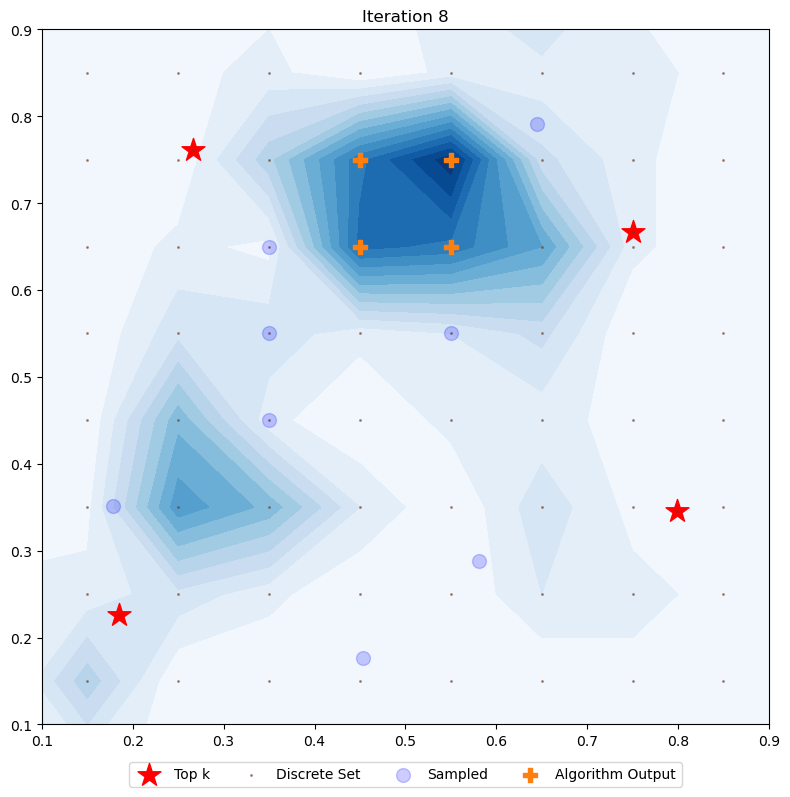

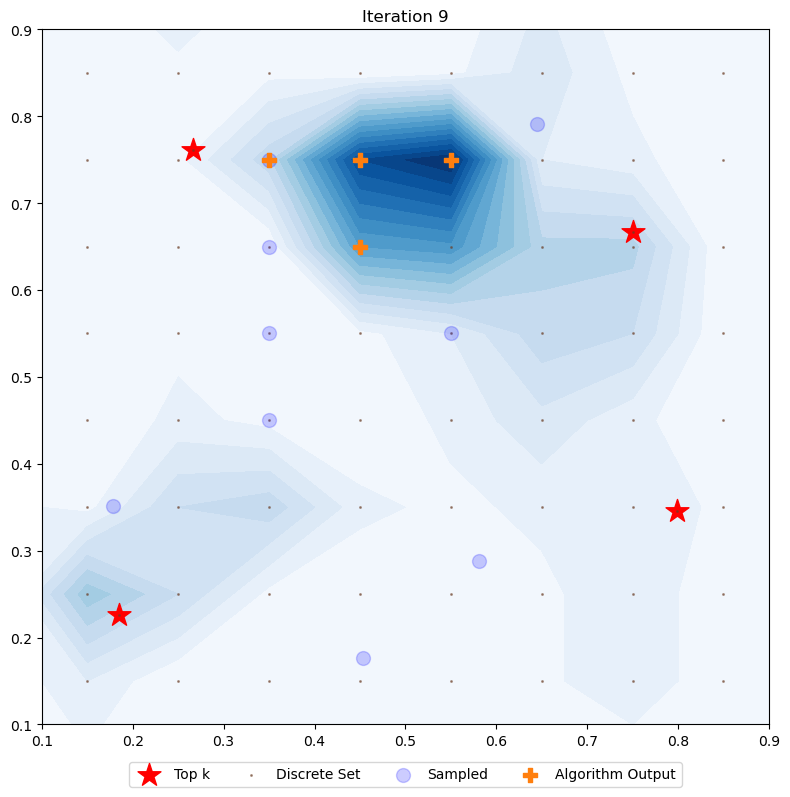

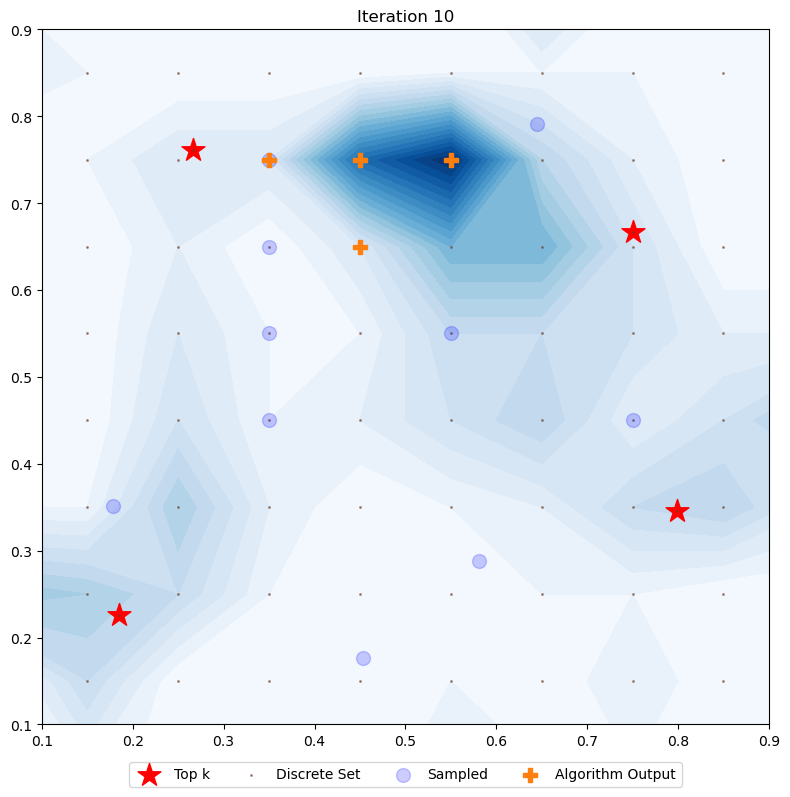

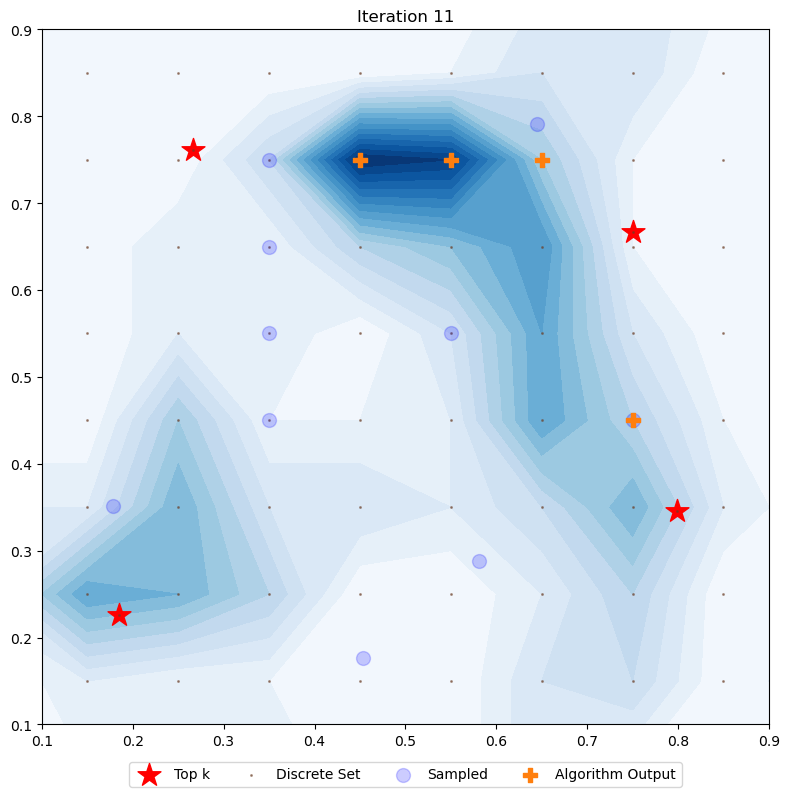

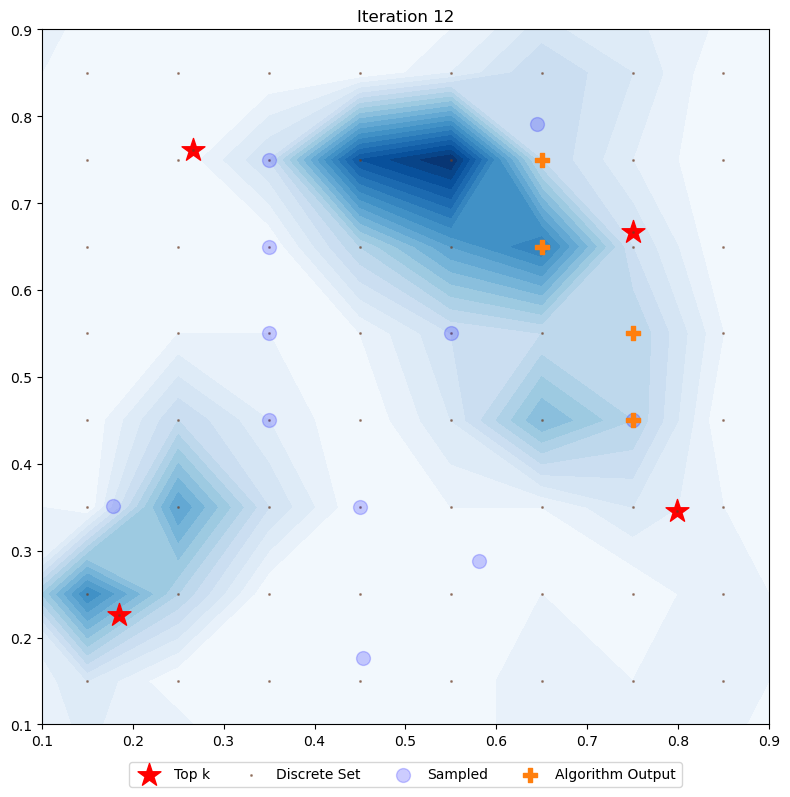

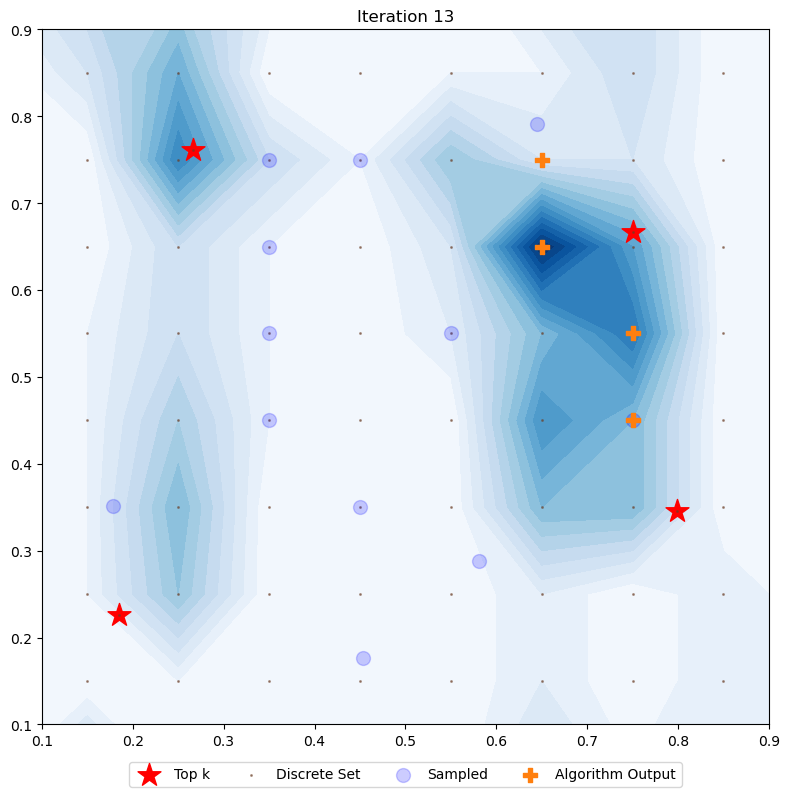

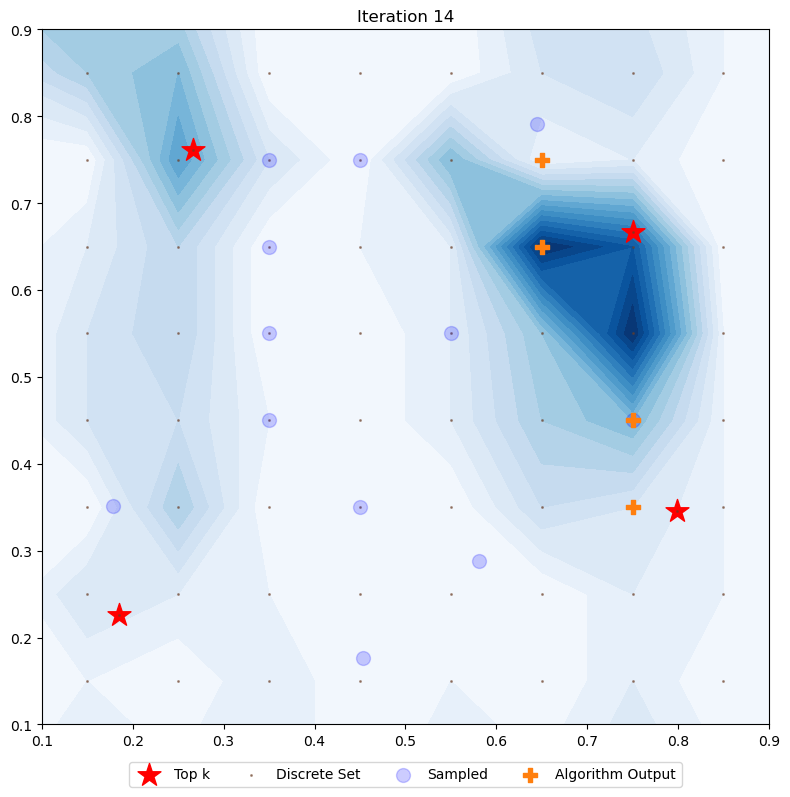

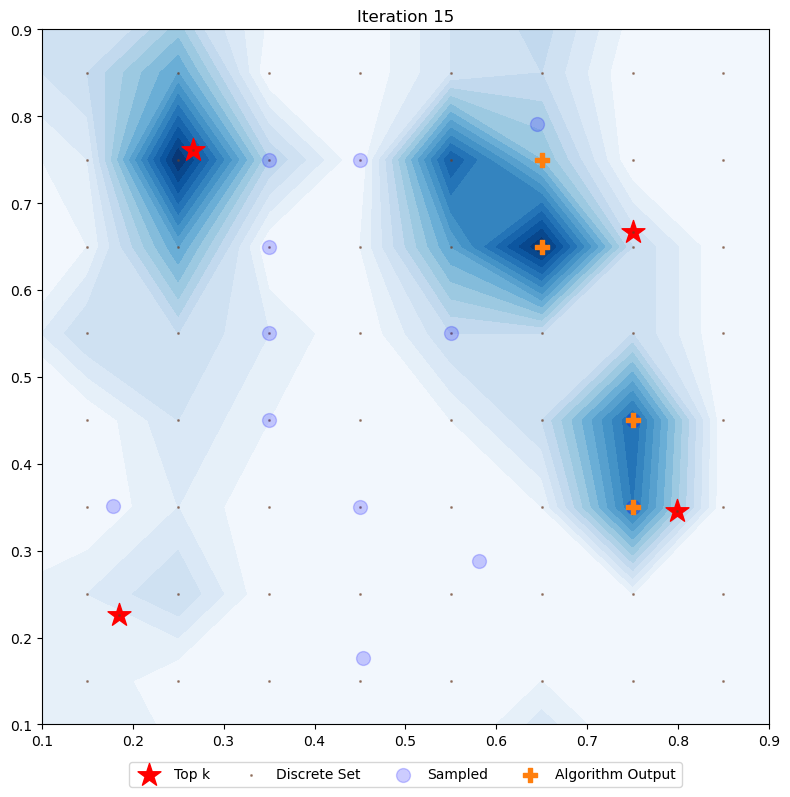

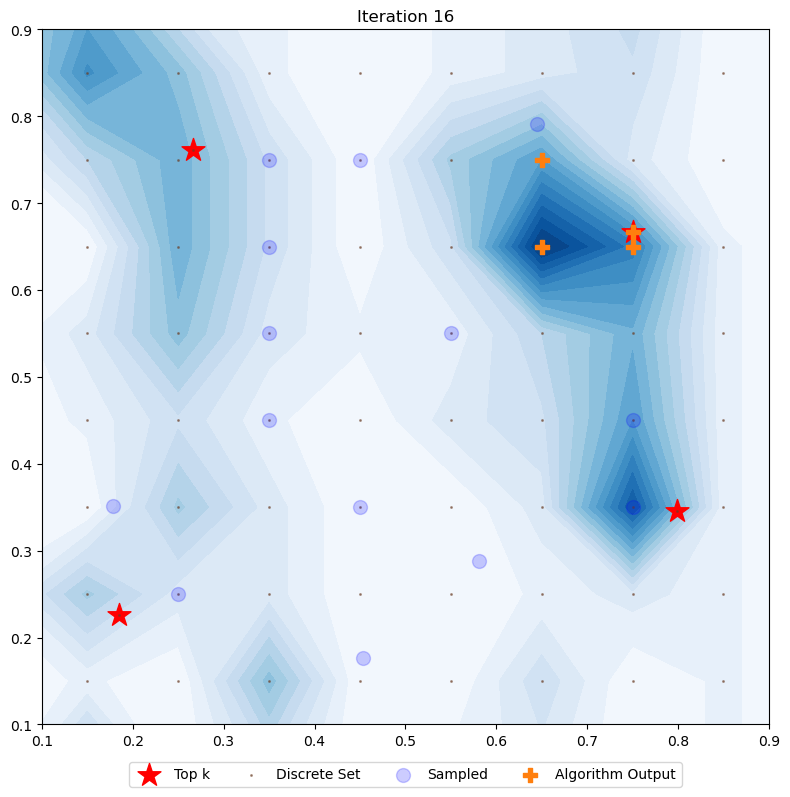

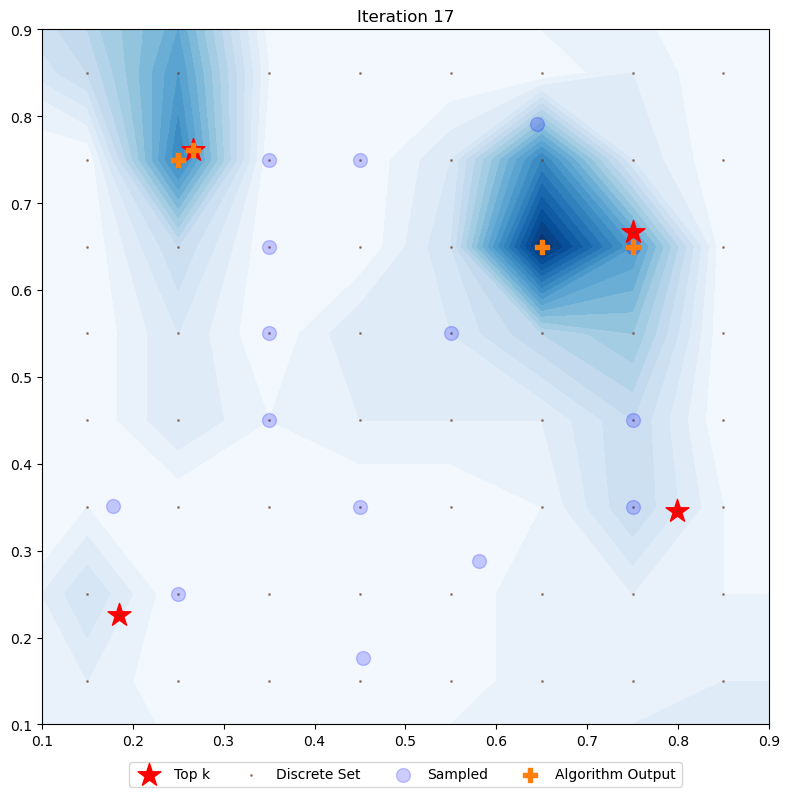

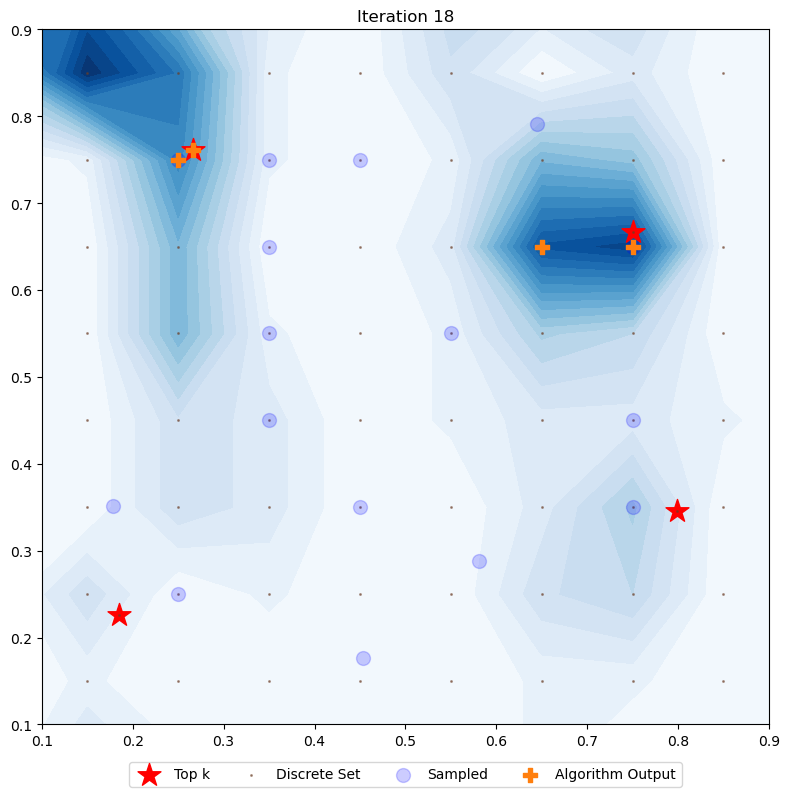

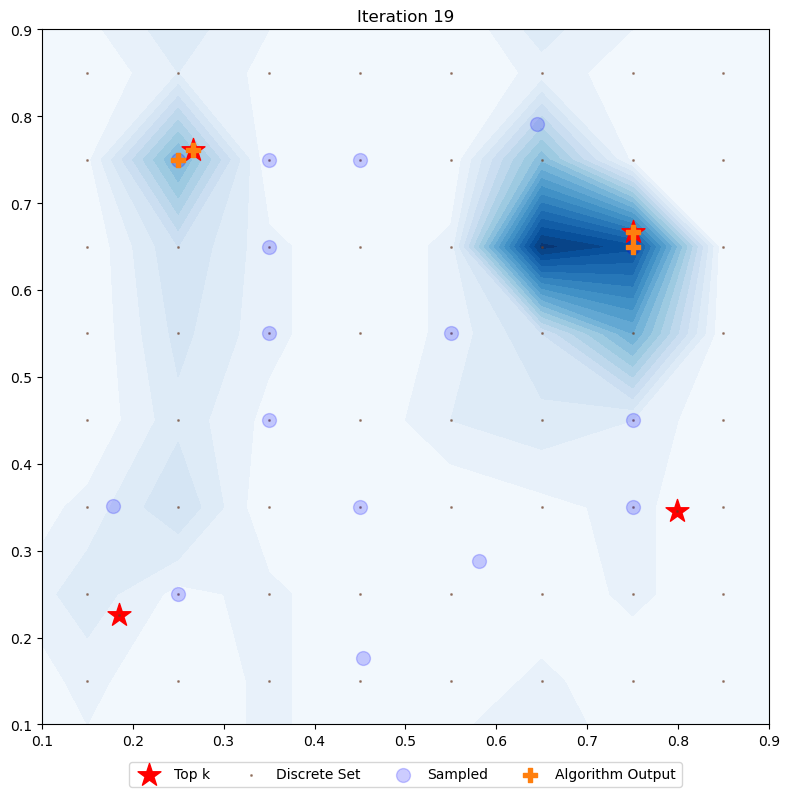

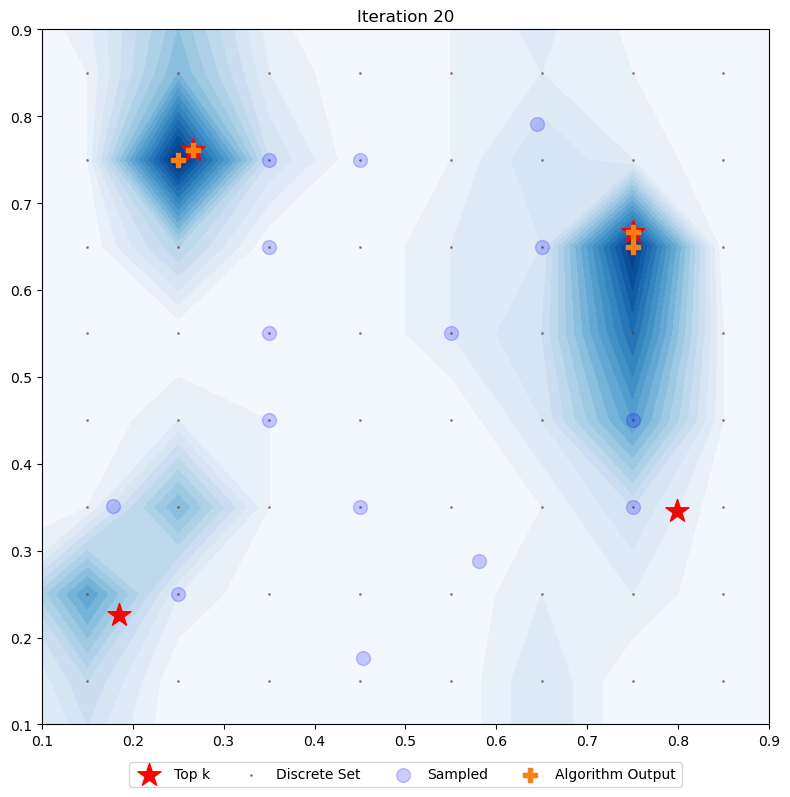

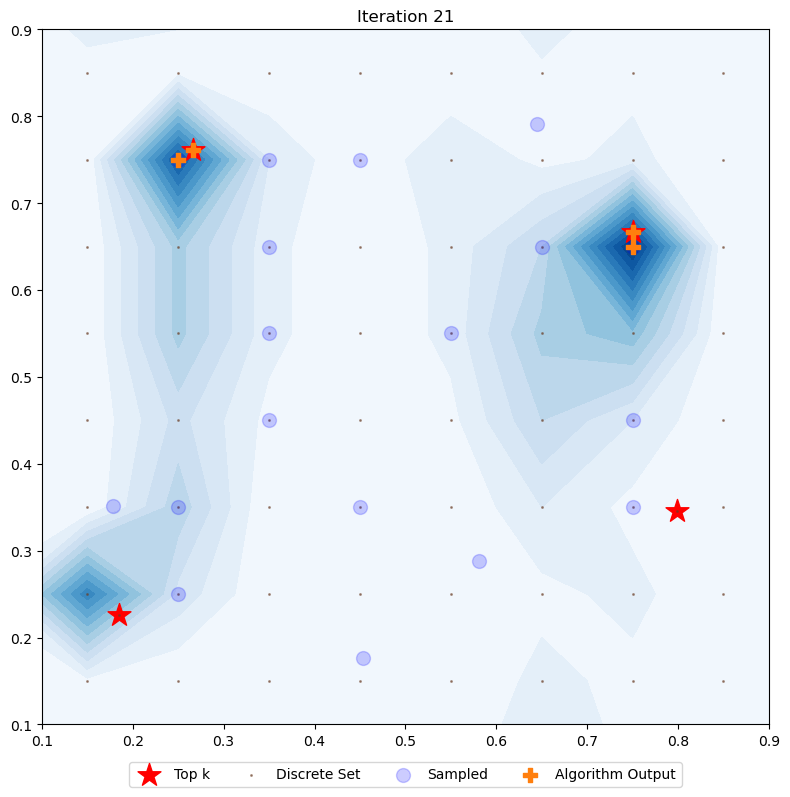

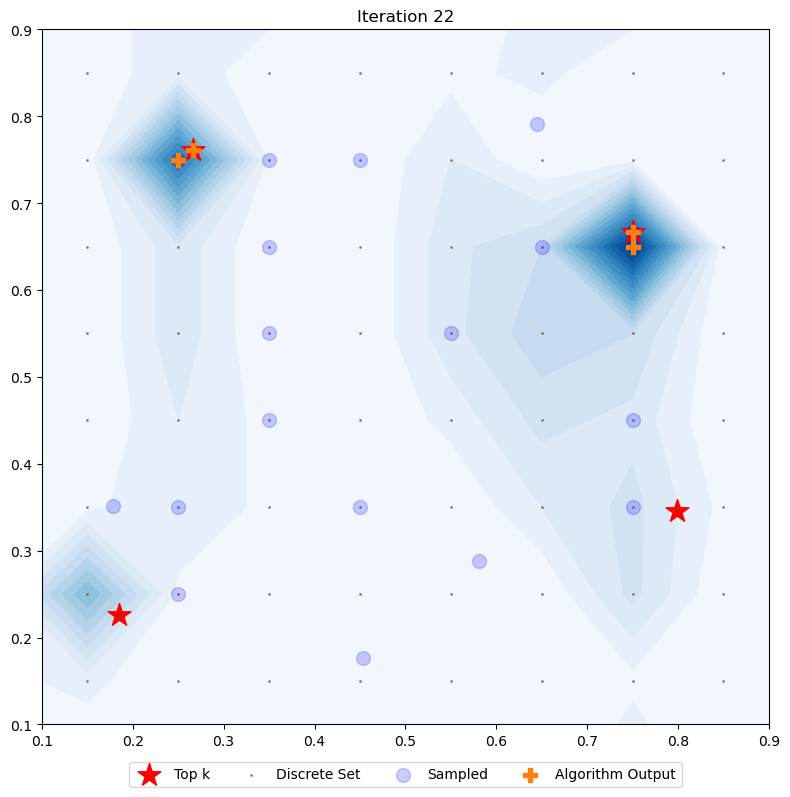

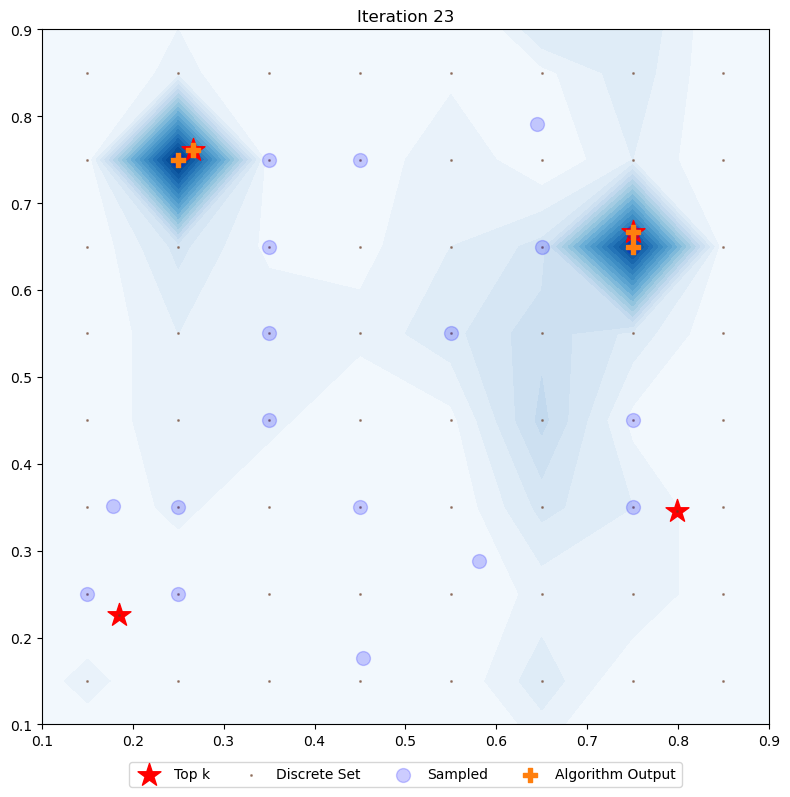

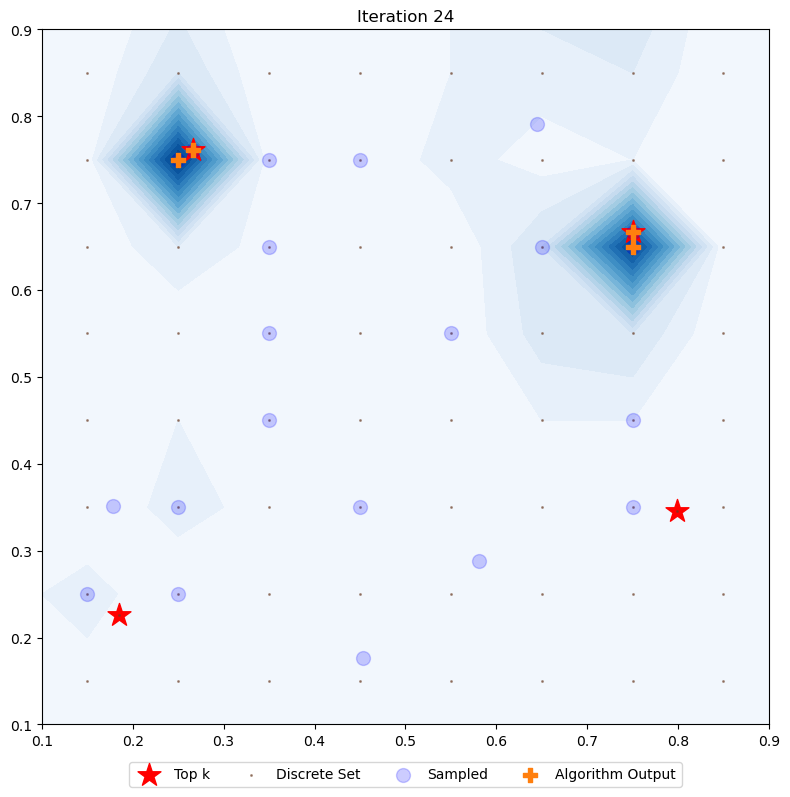

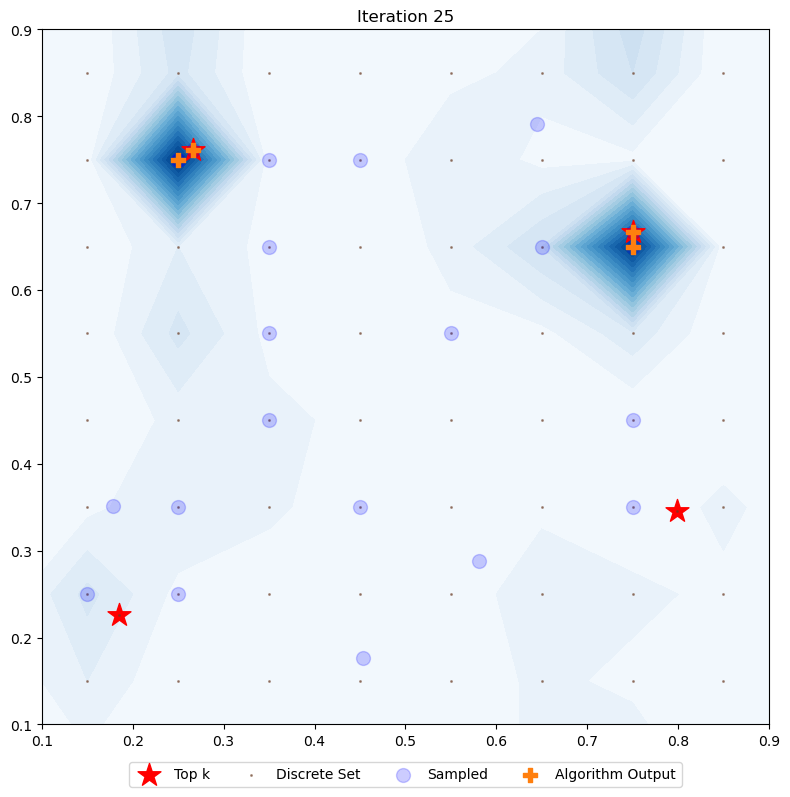

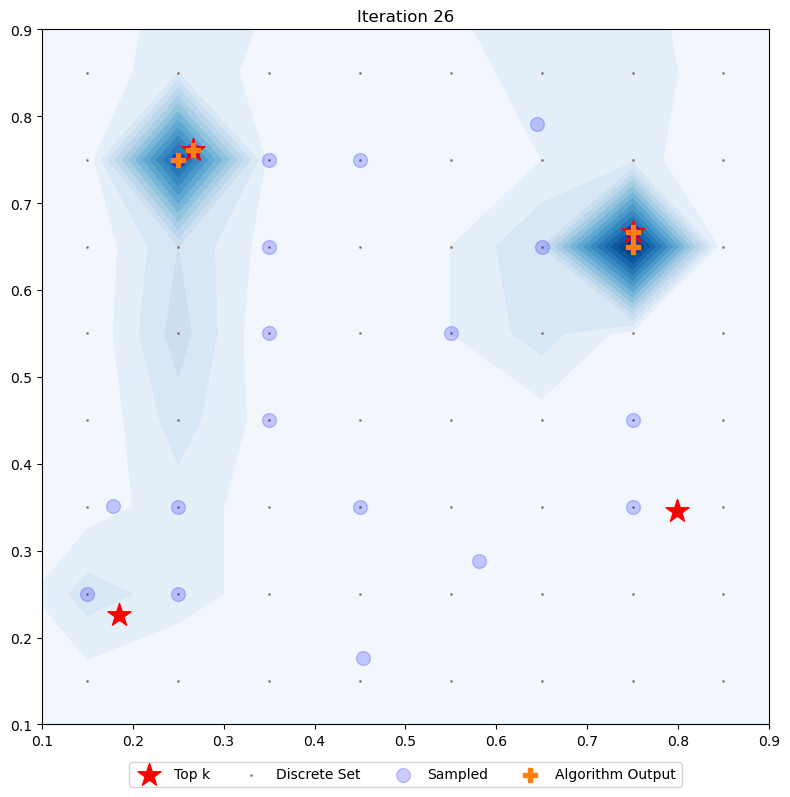

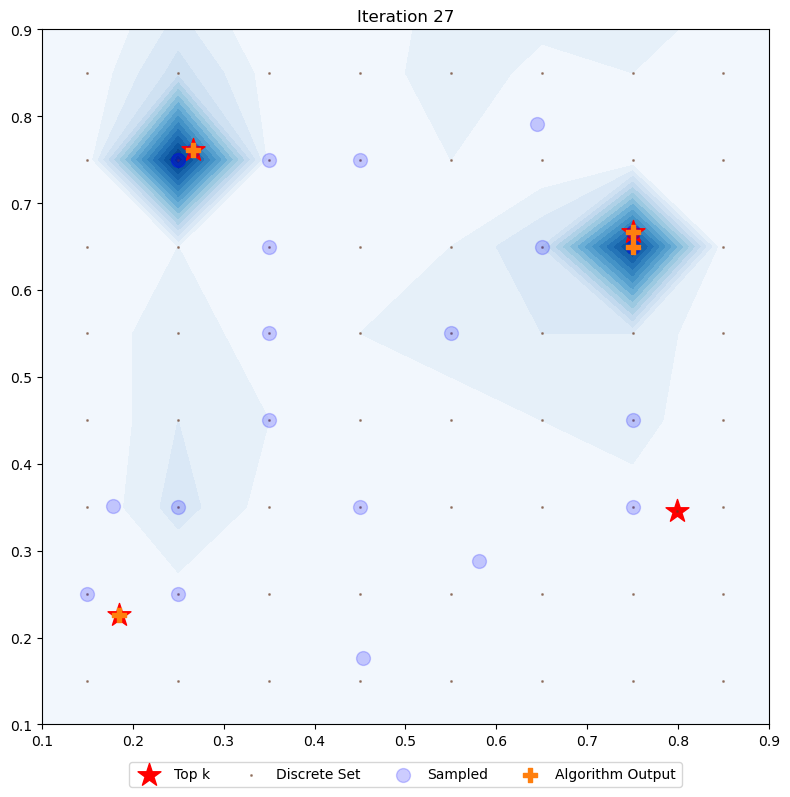

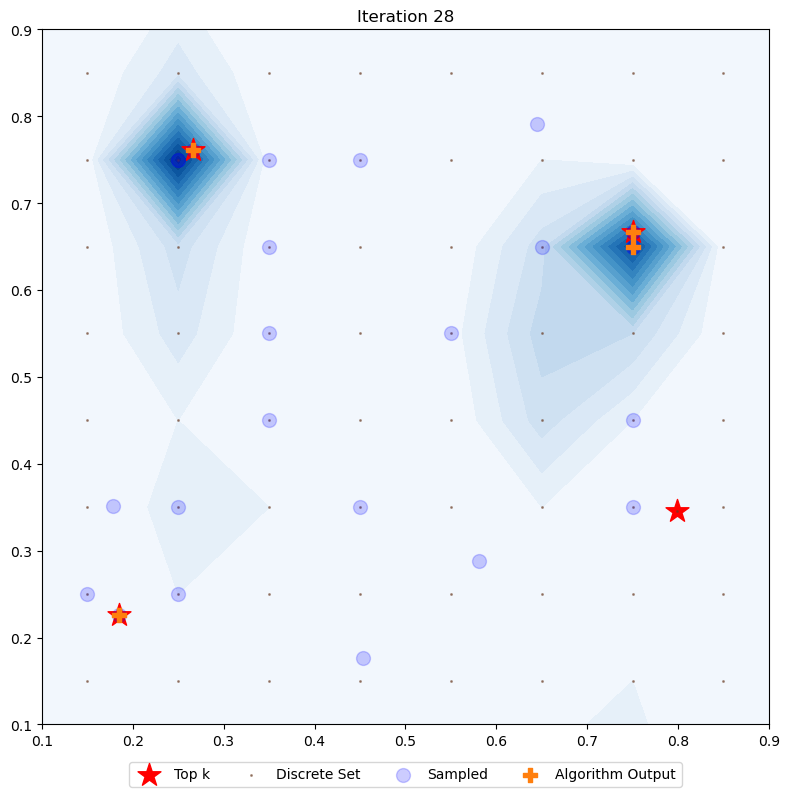

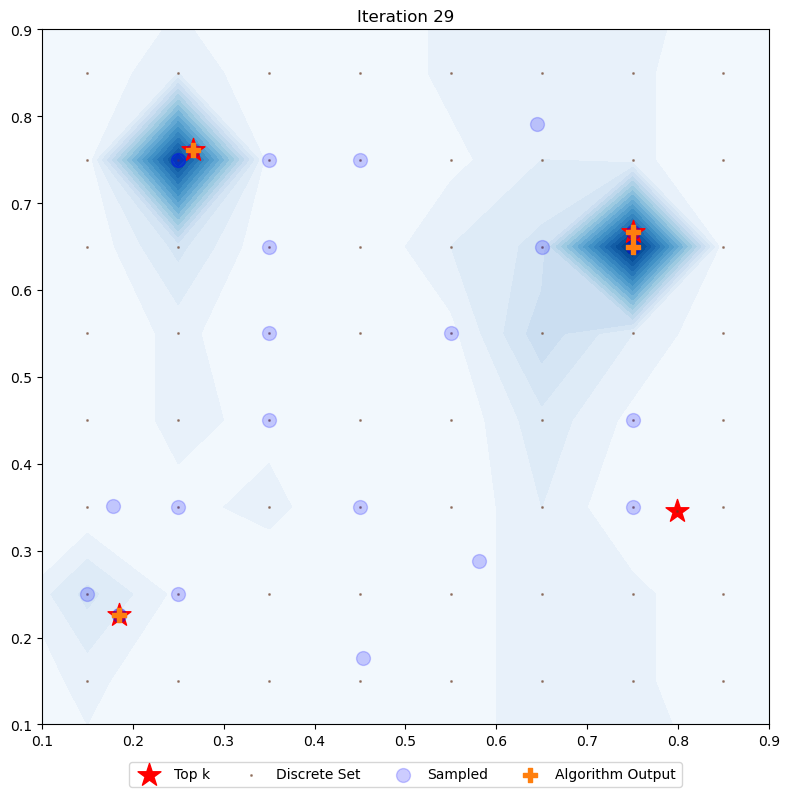

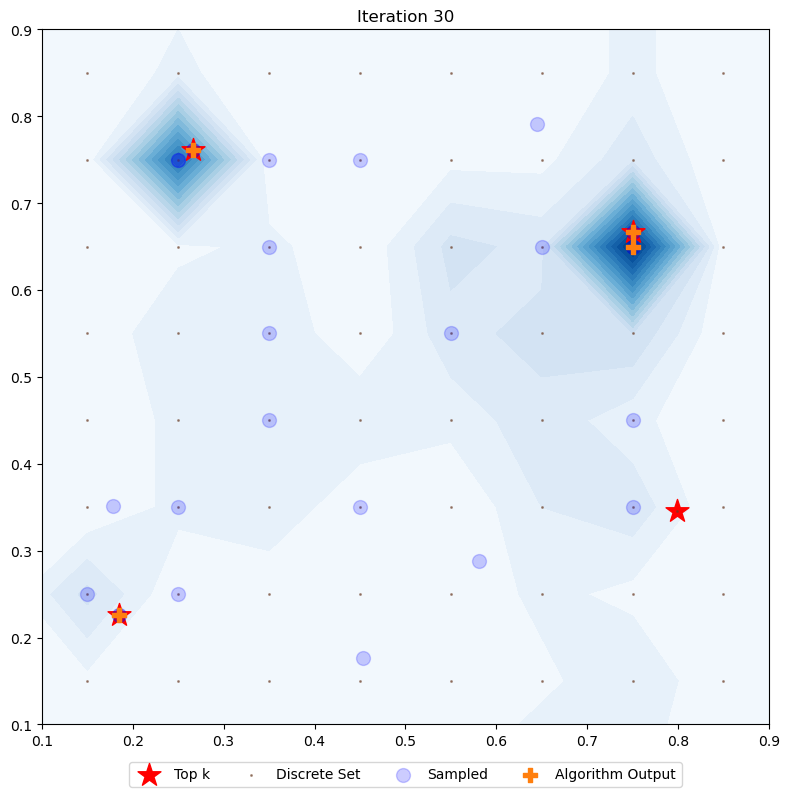

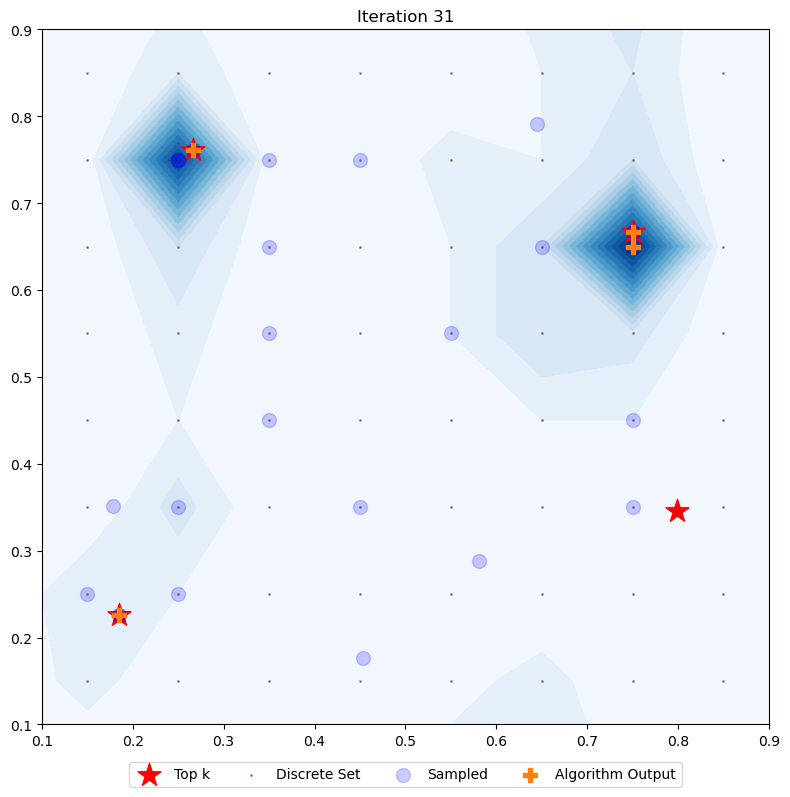

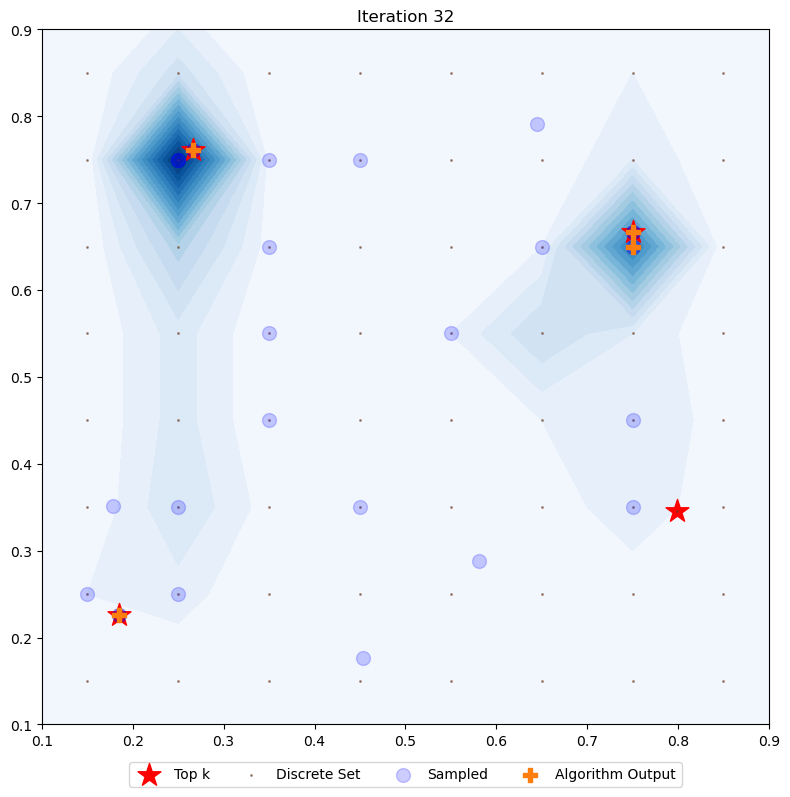

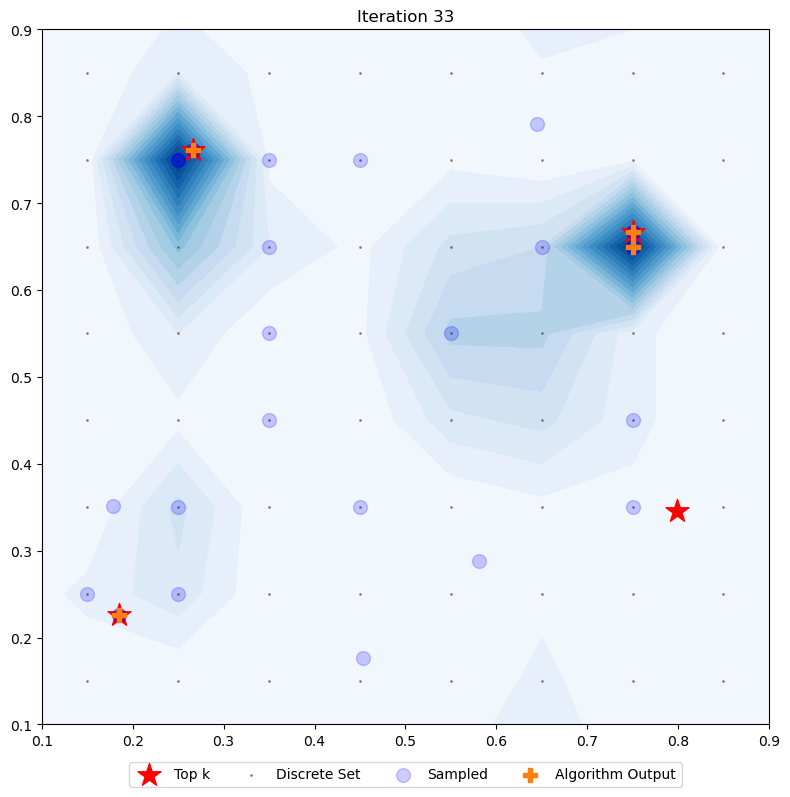

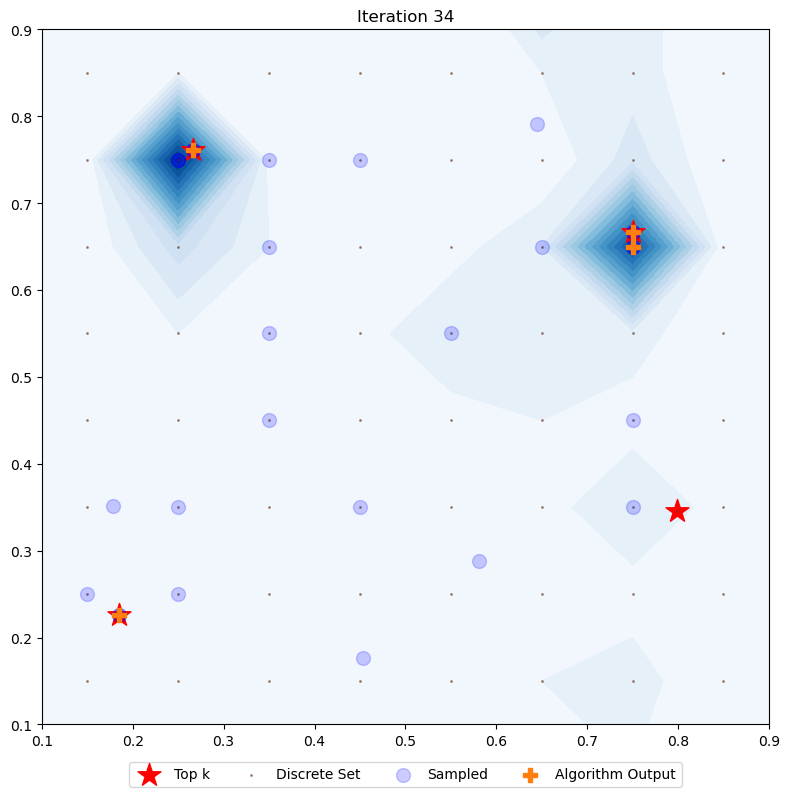

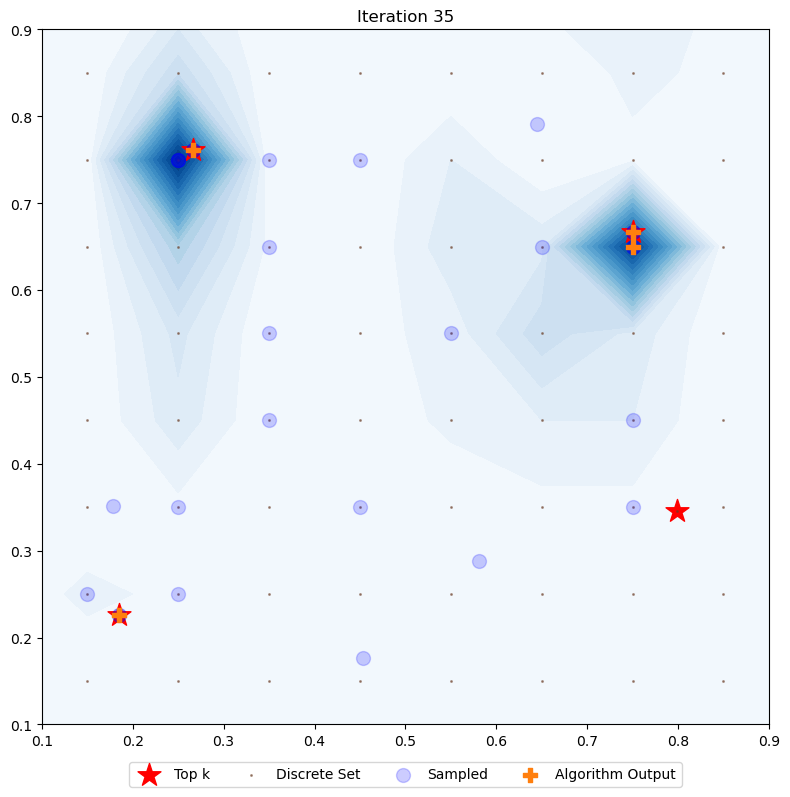

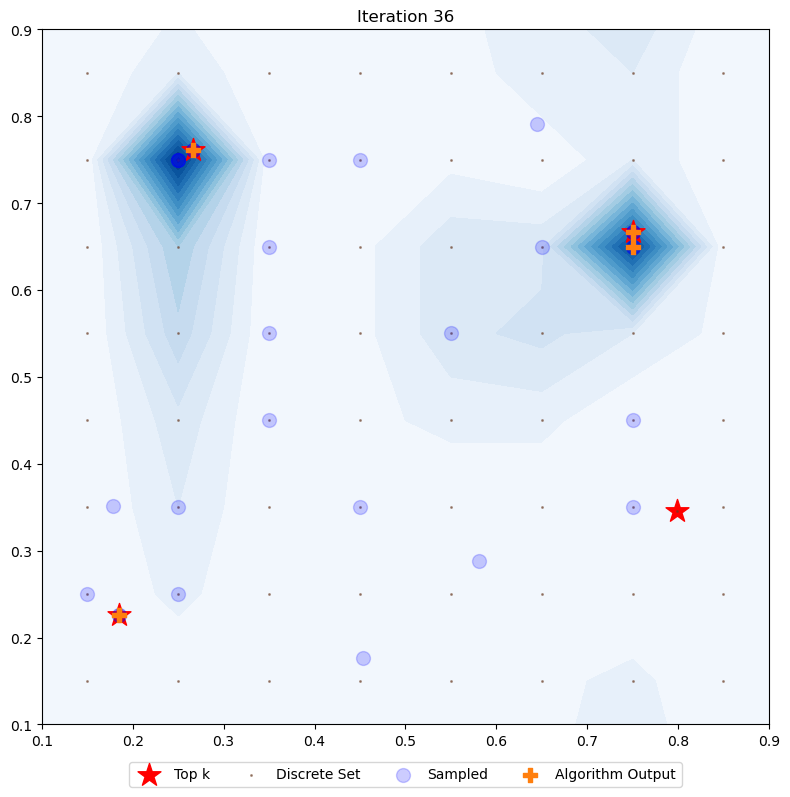

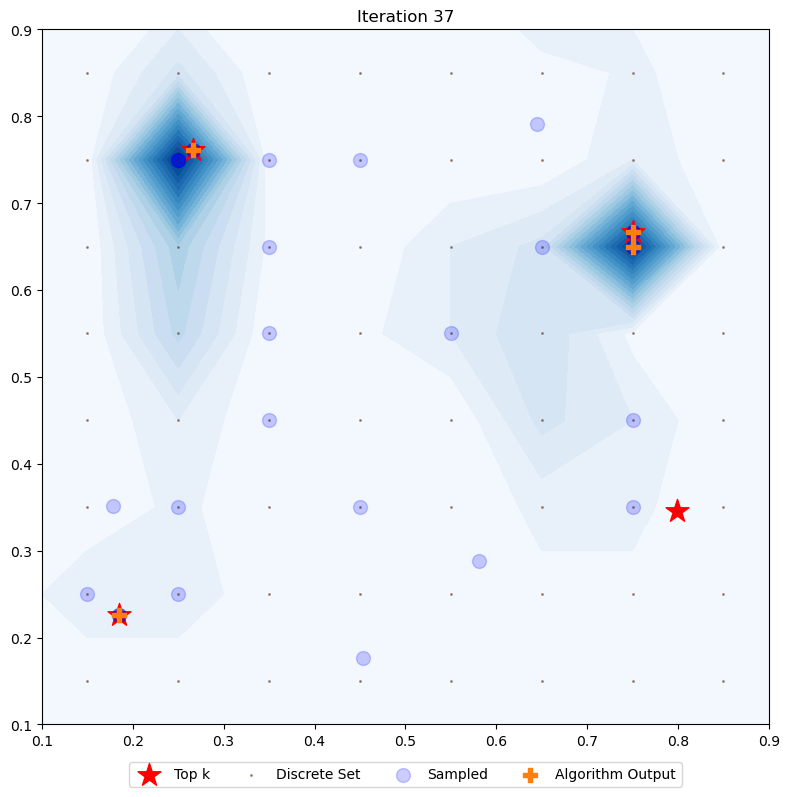

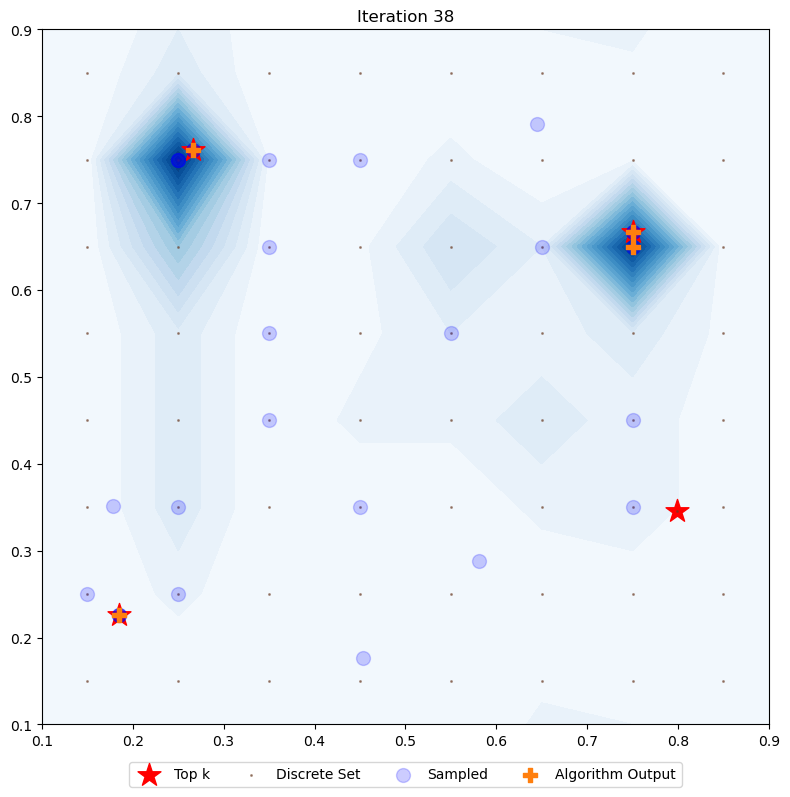

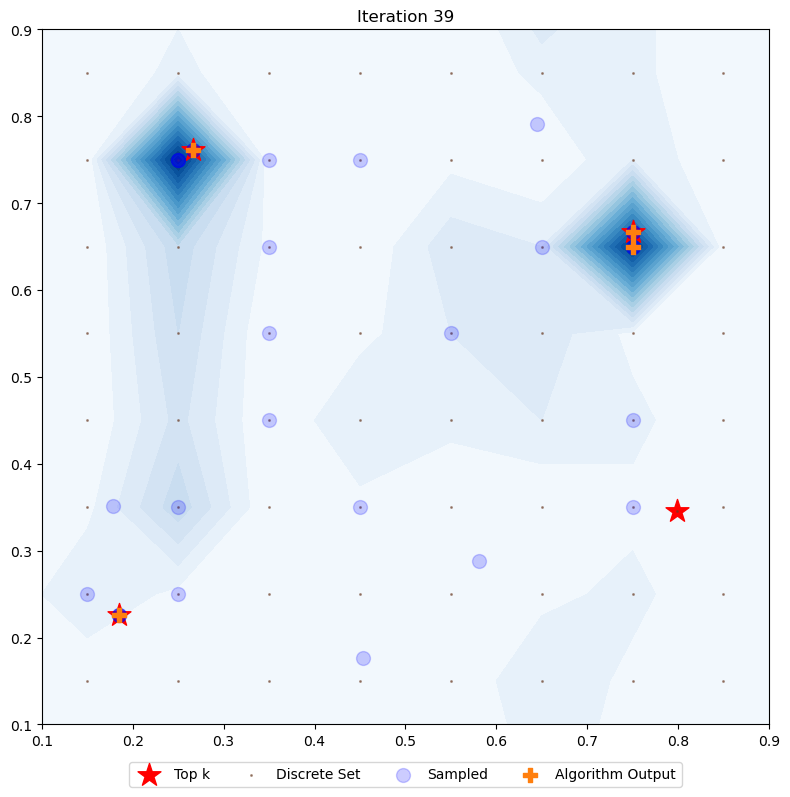

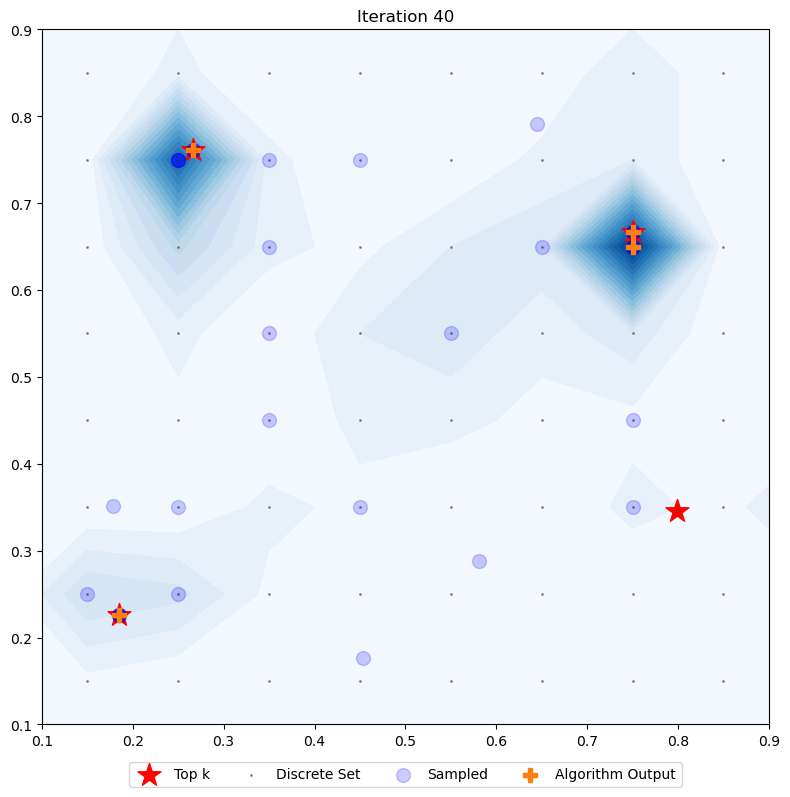

In [102]:
for i in range(max_iter):
    plot("ps", PATH_ps)
    # plot("bax", PATH_bax)
    

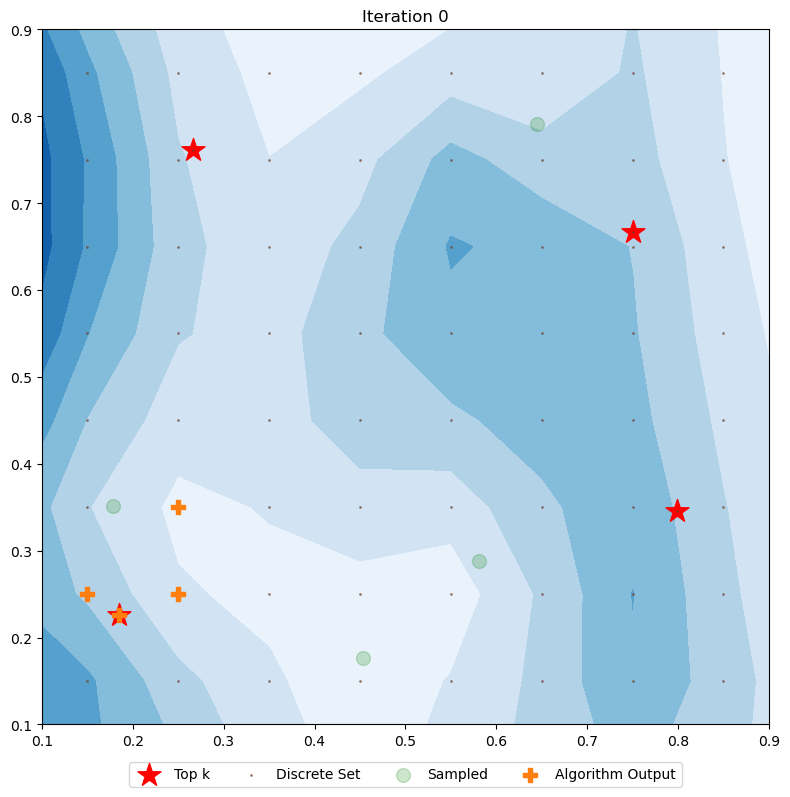

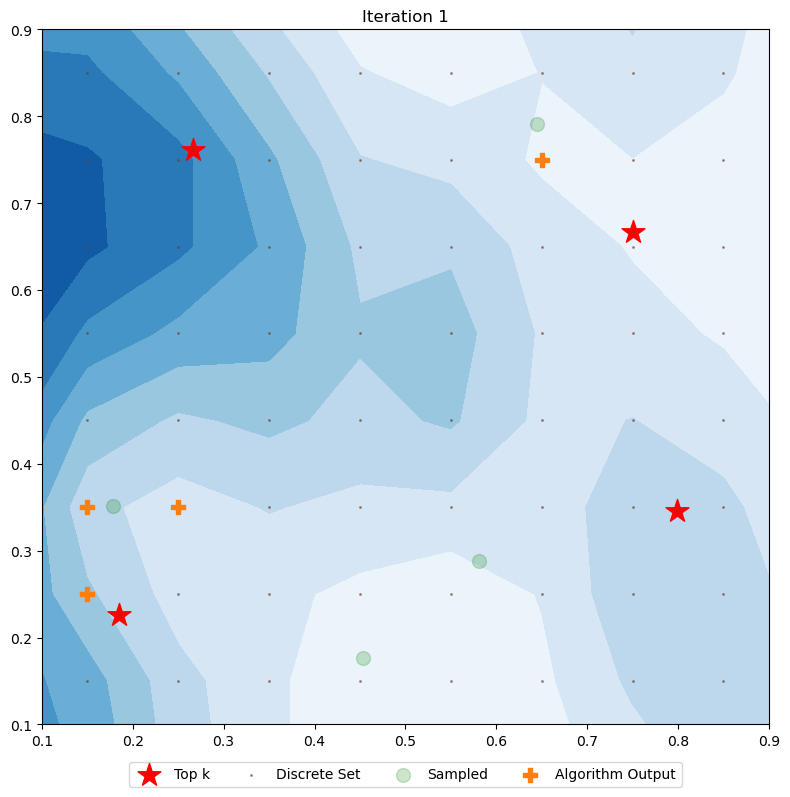

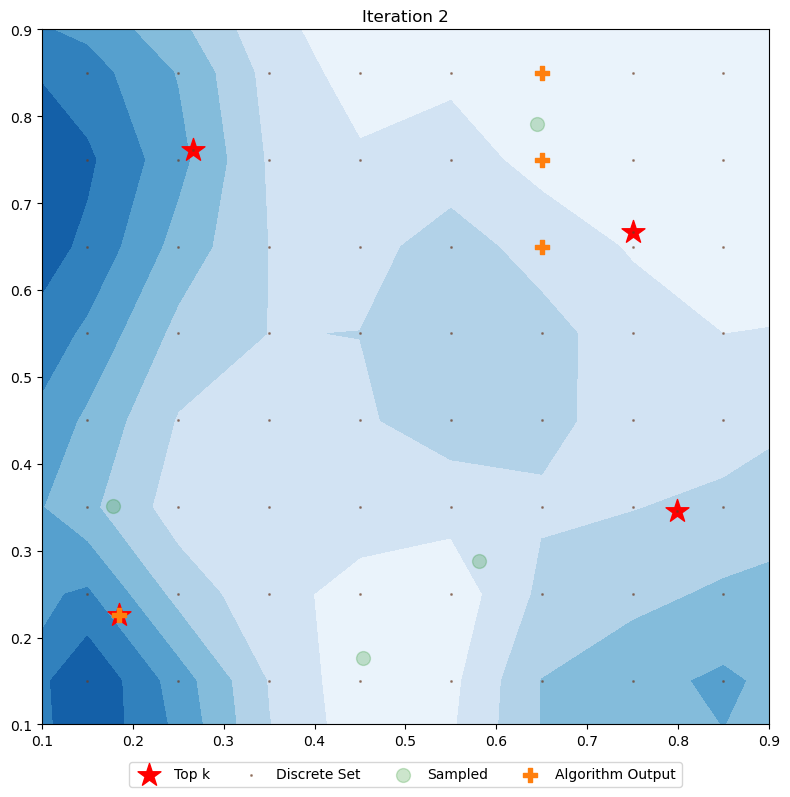

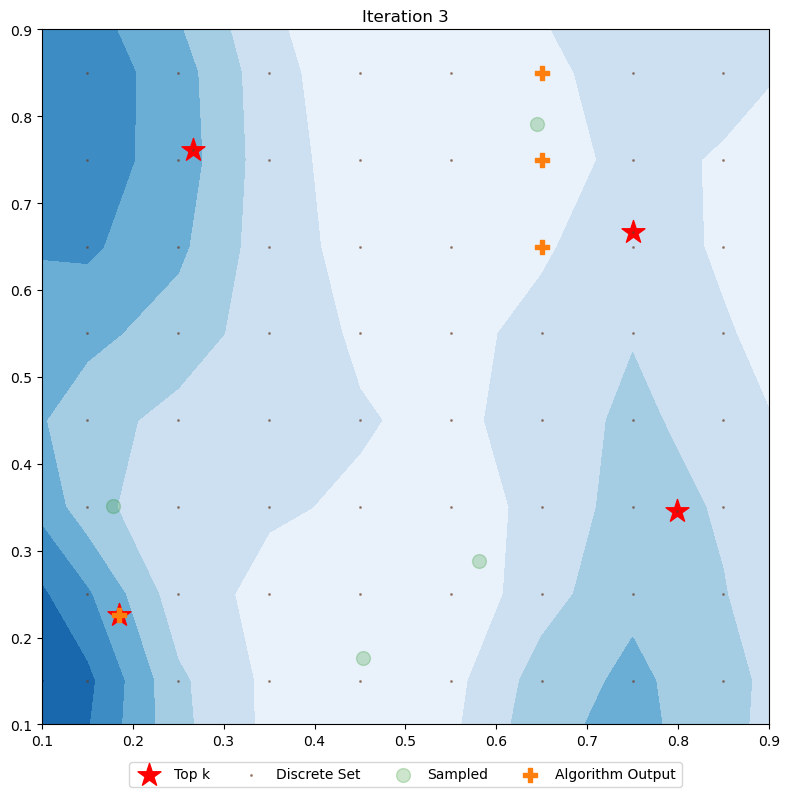

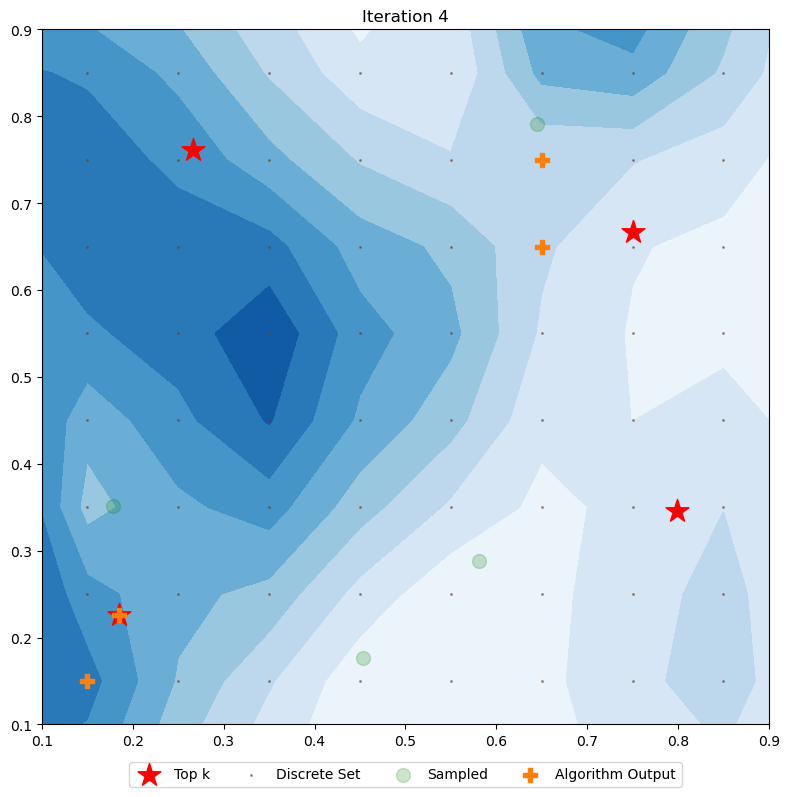

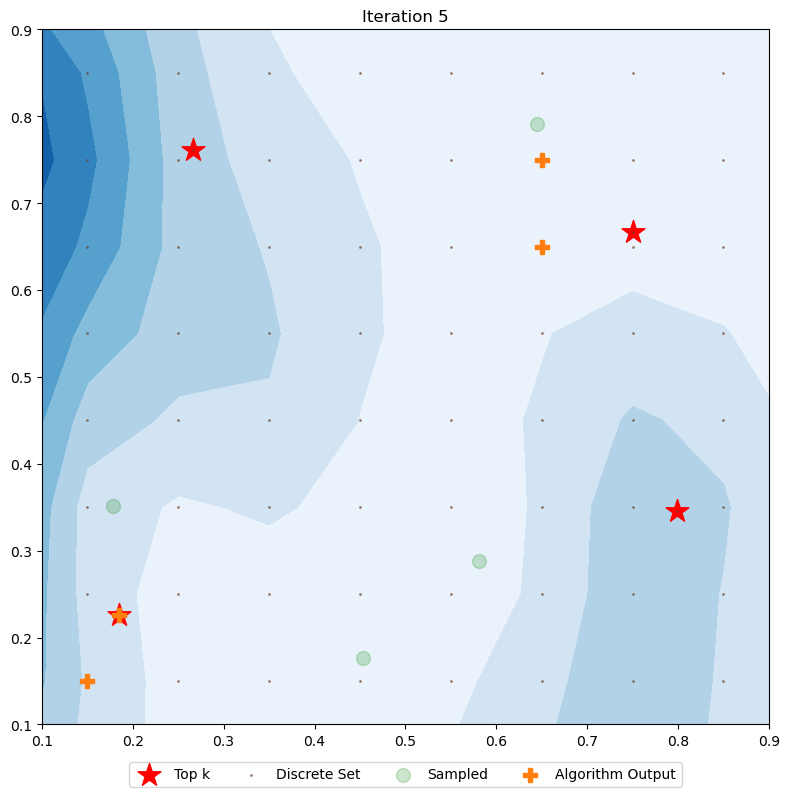

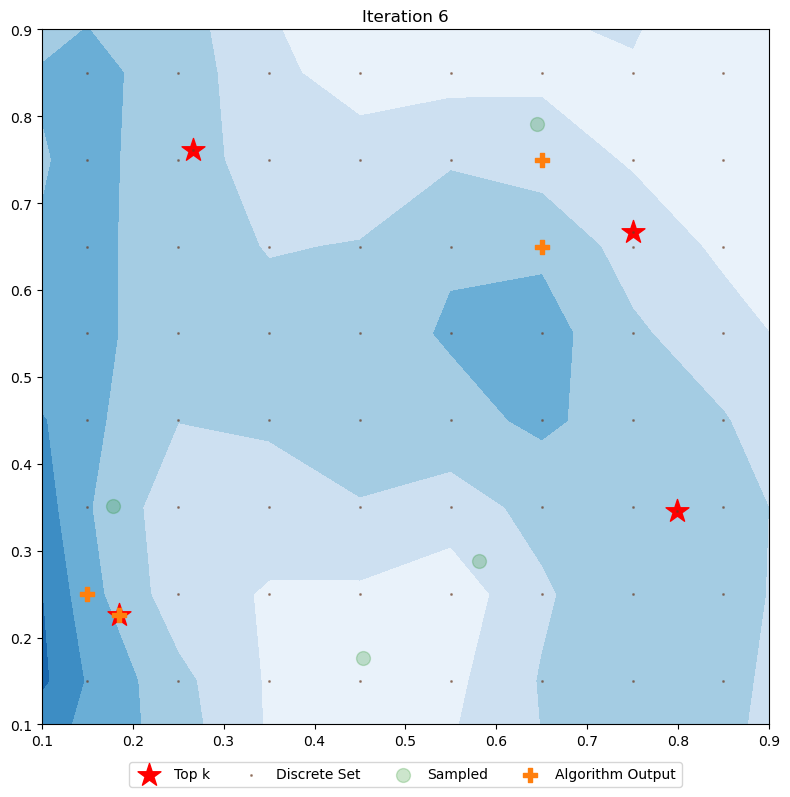

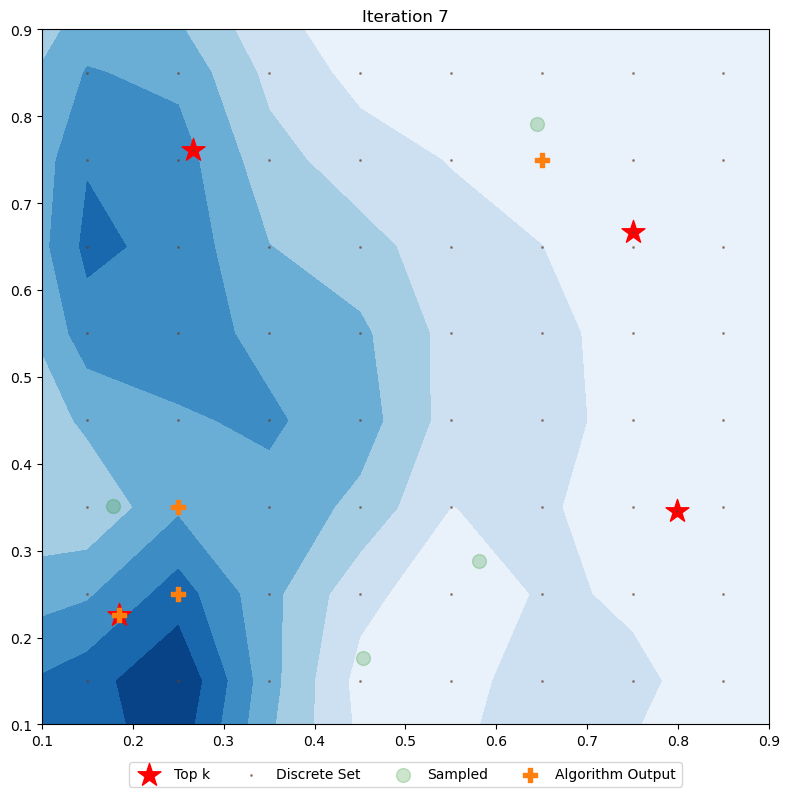

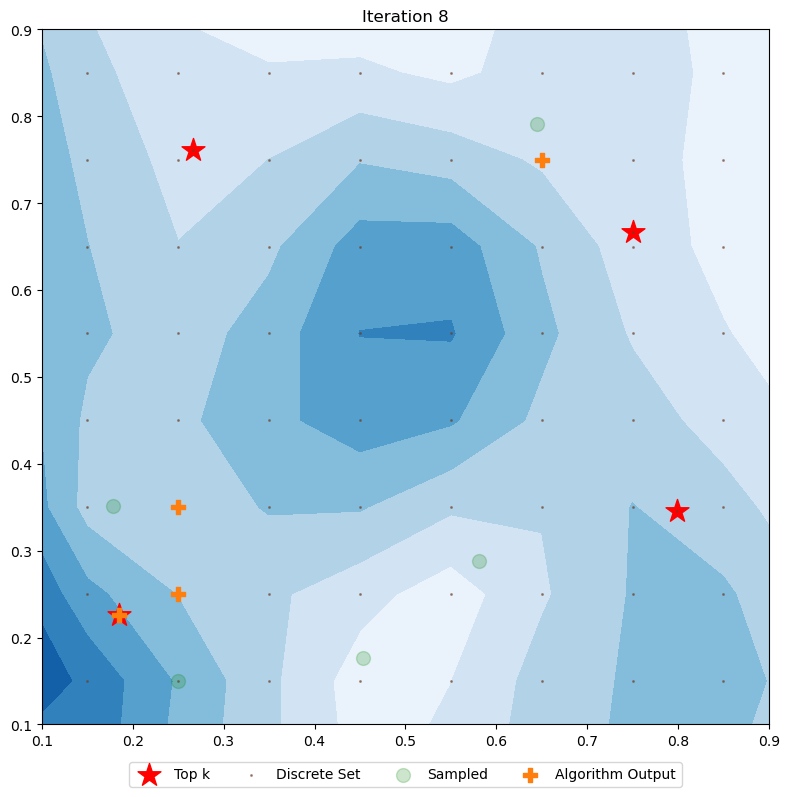

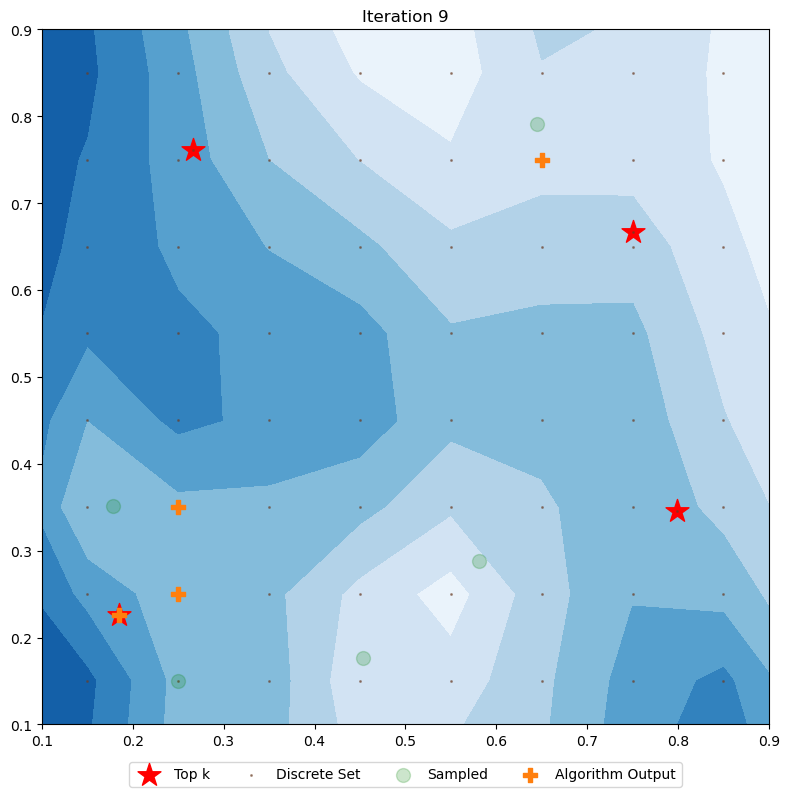

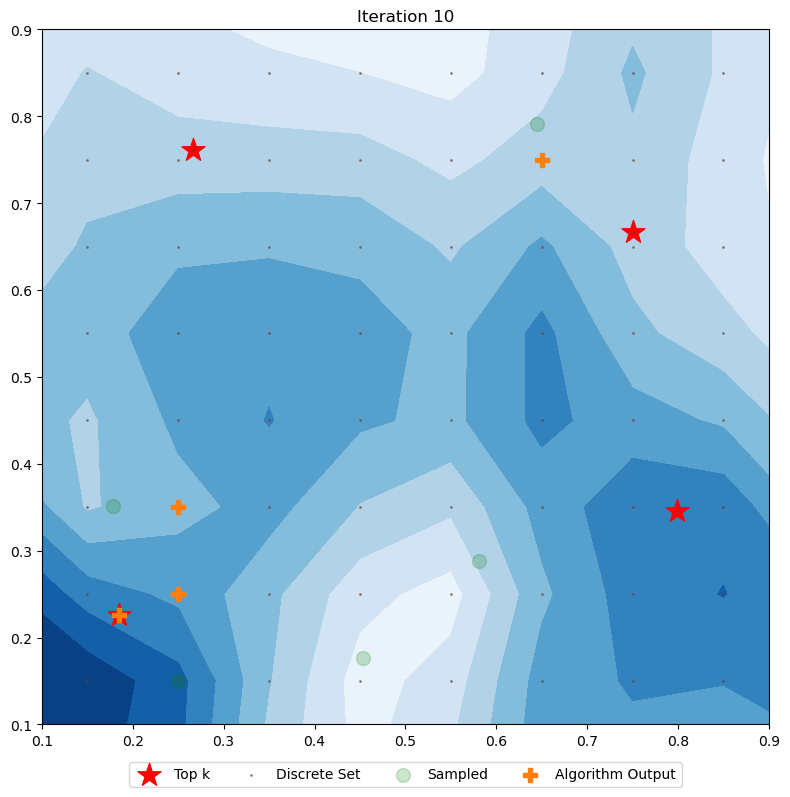

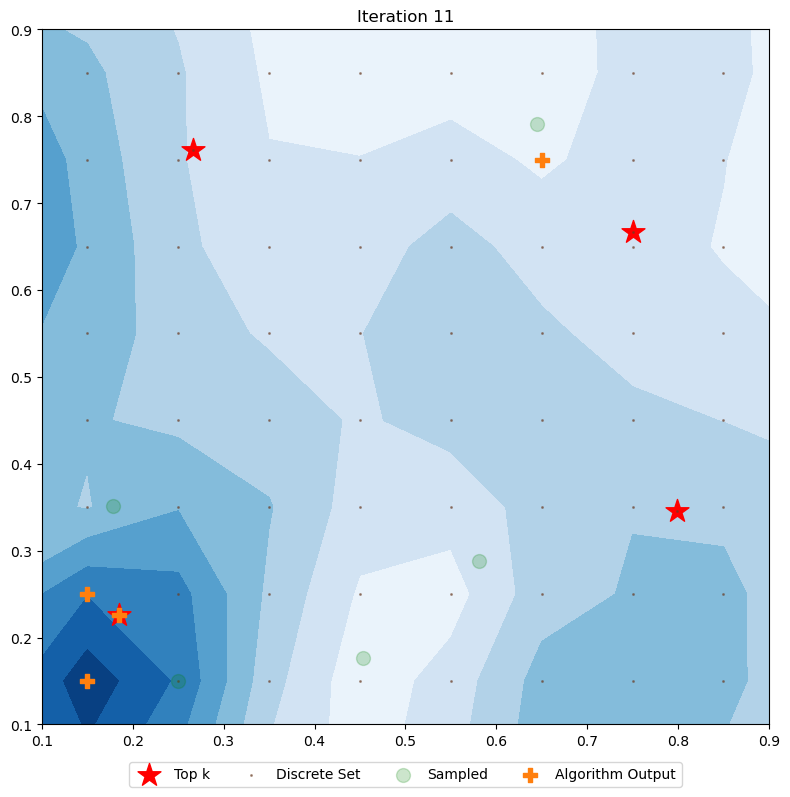

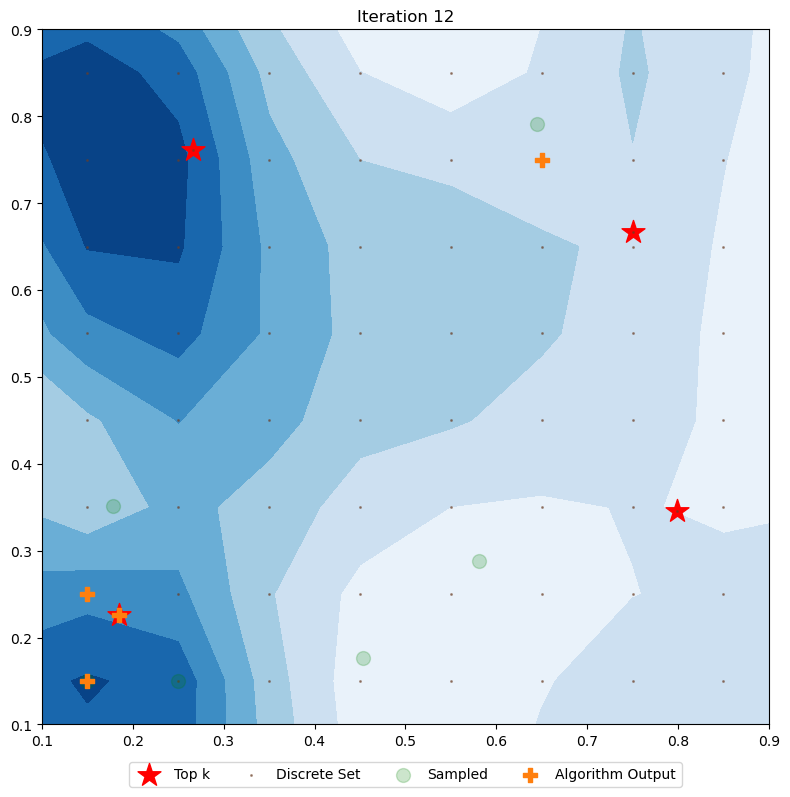

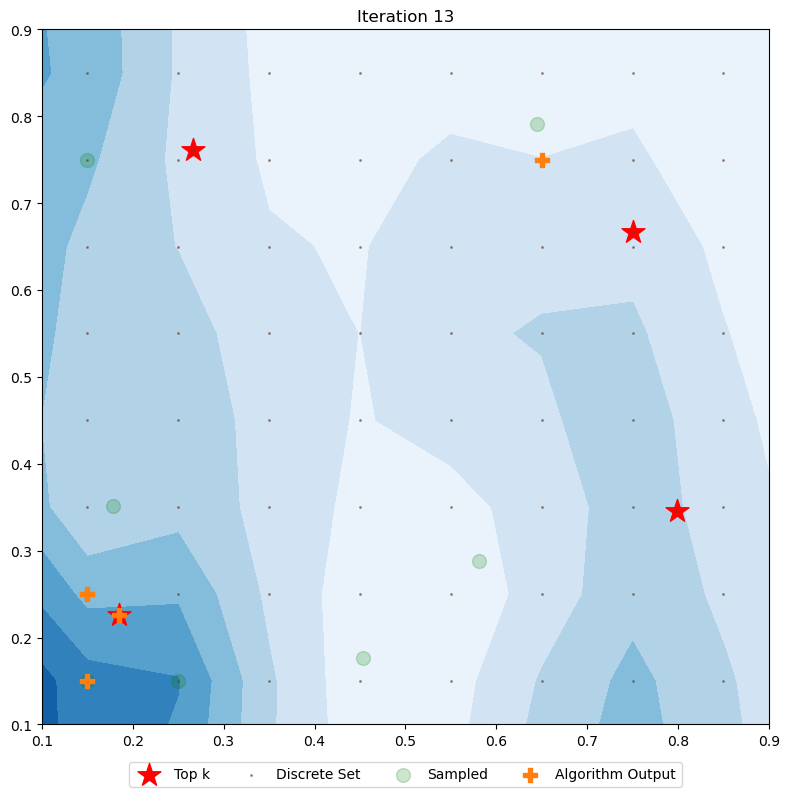

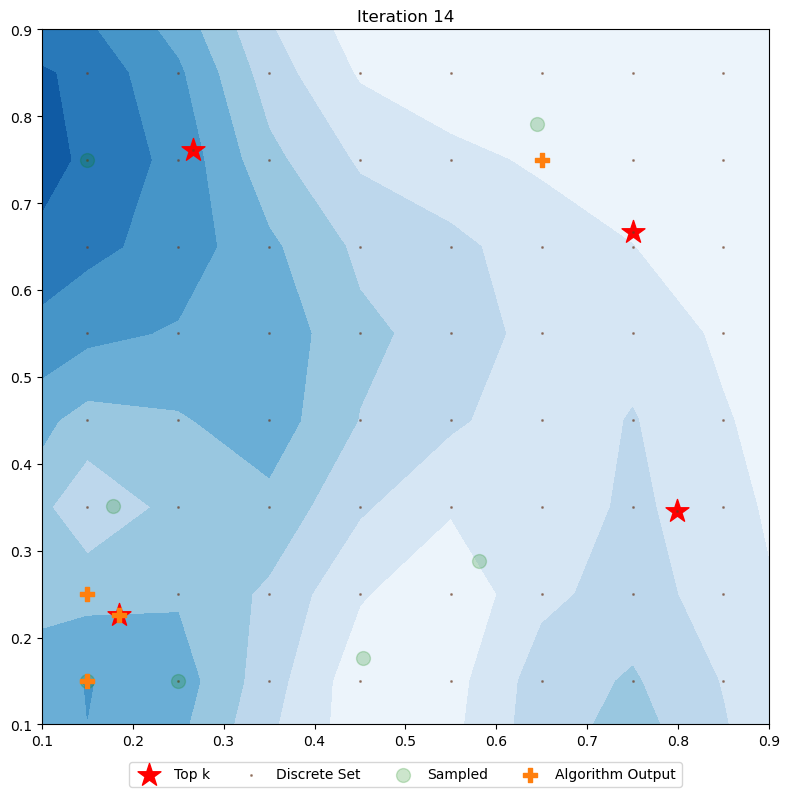

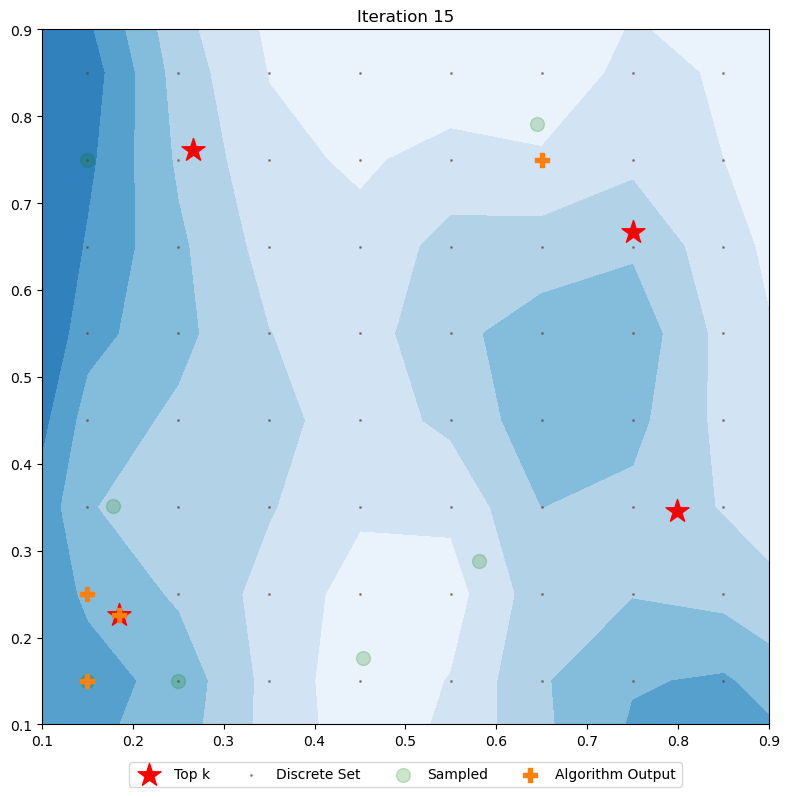

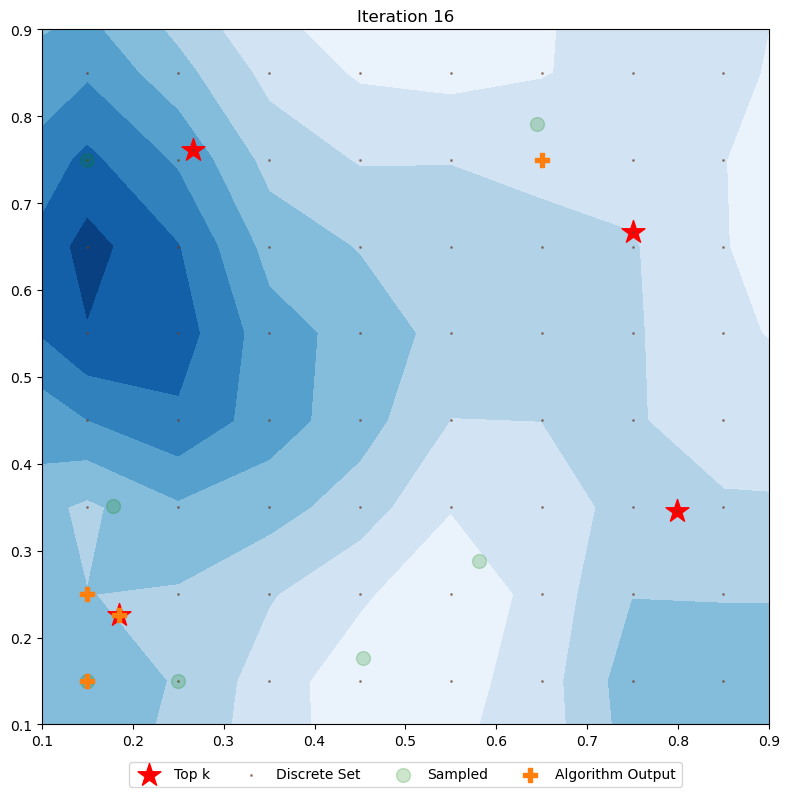

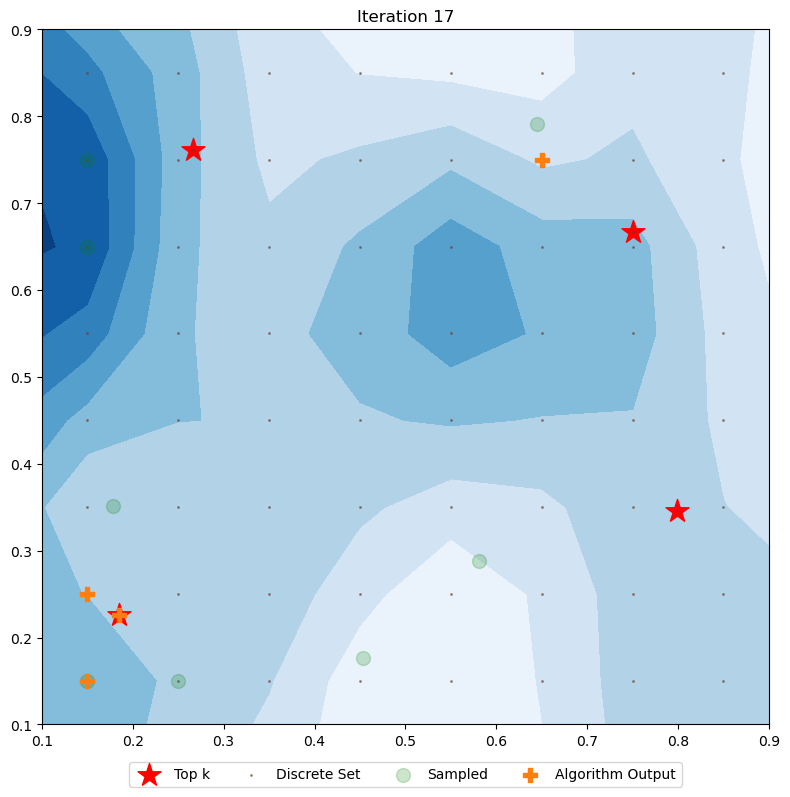

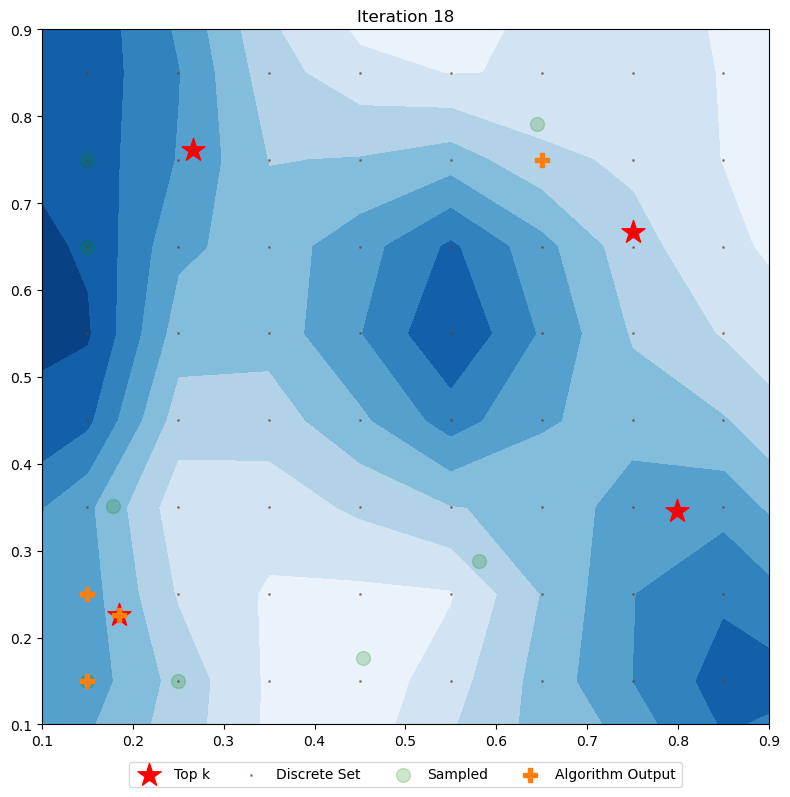

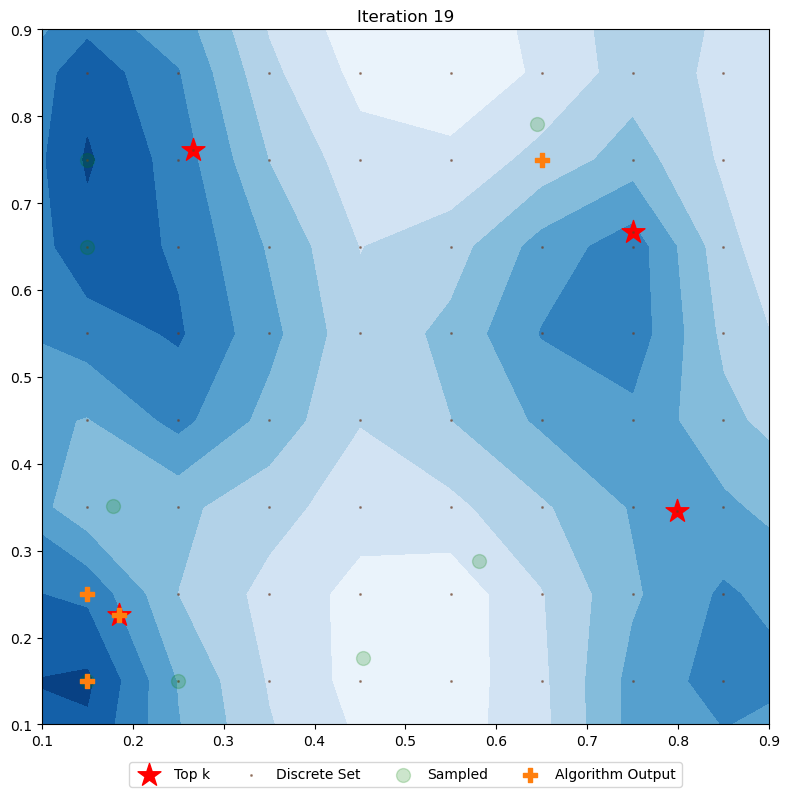

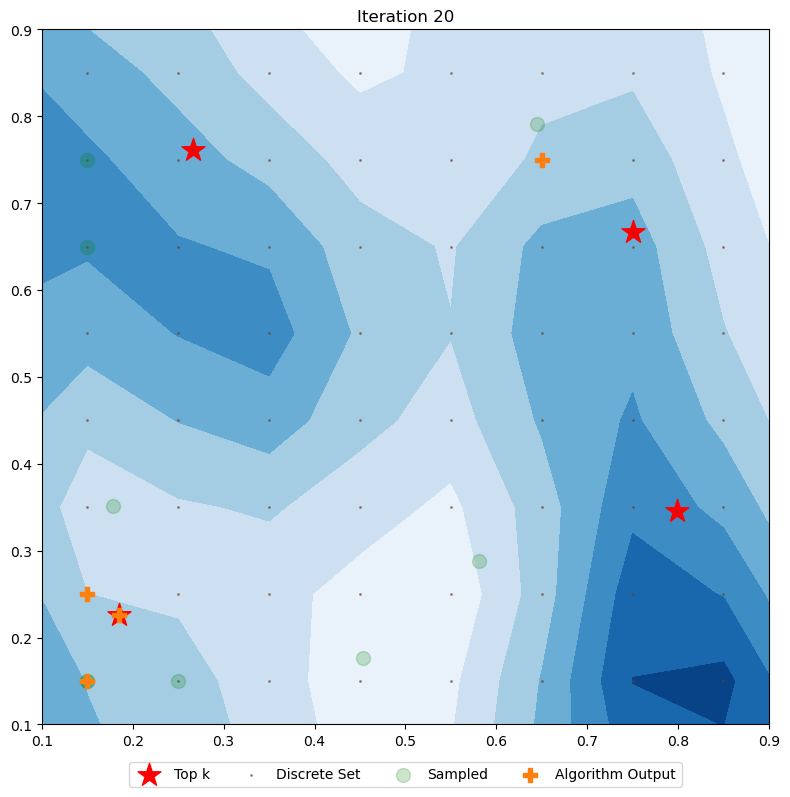

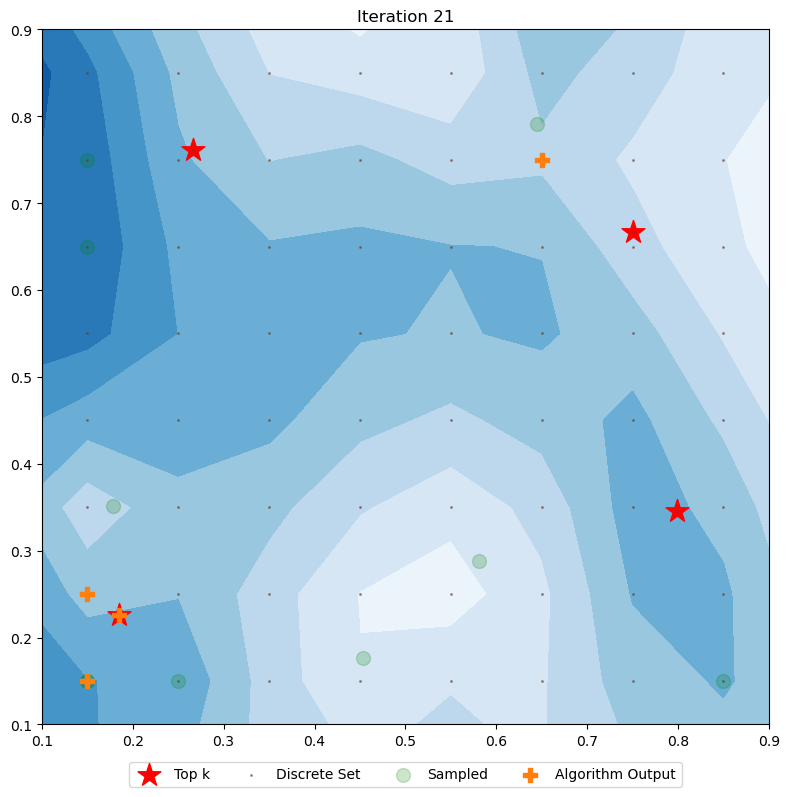

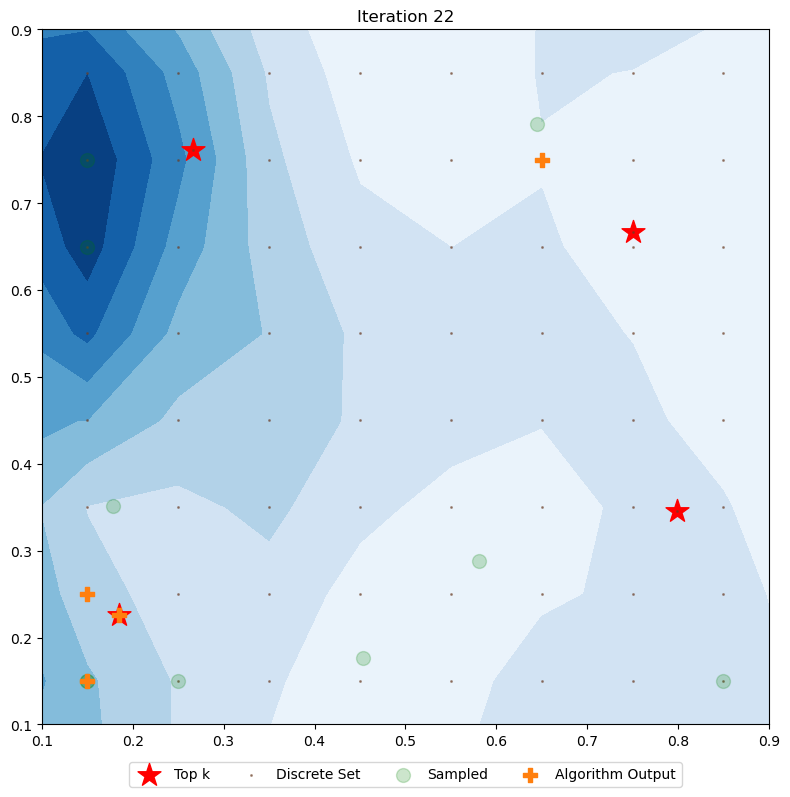

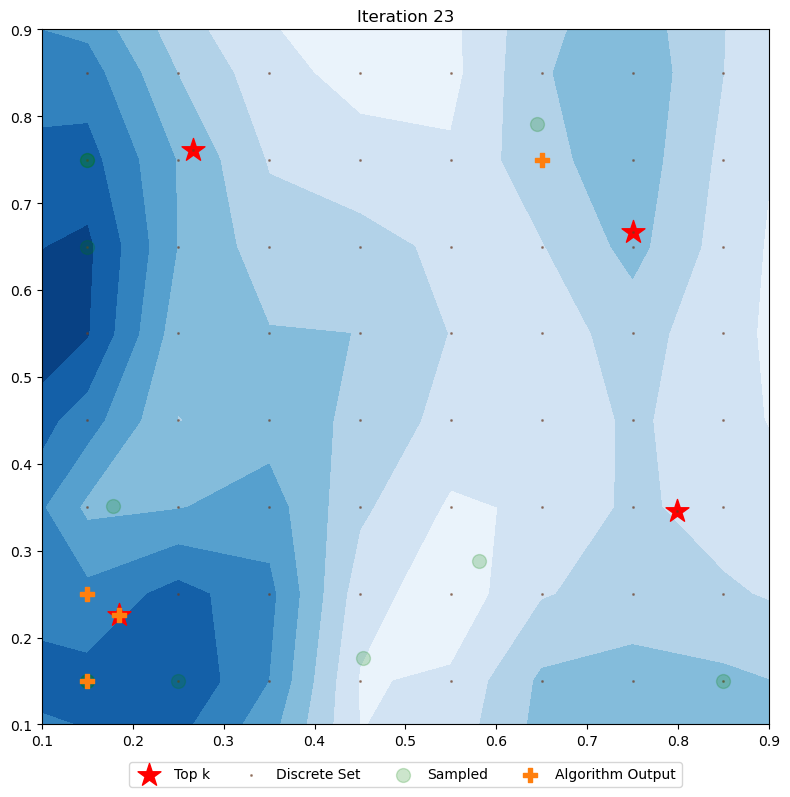

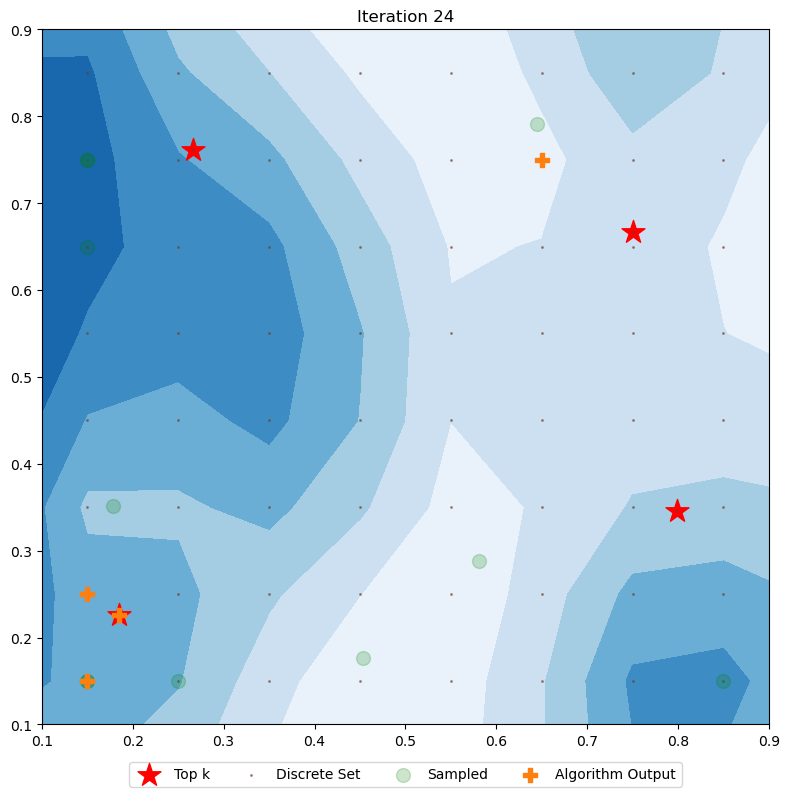

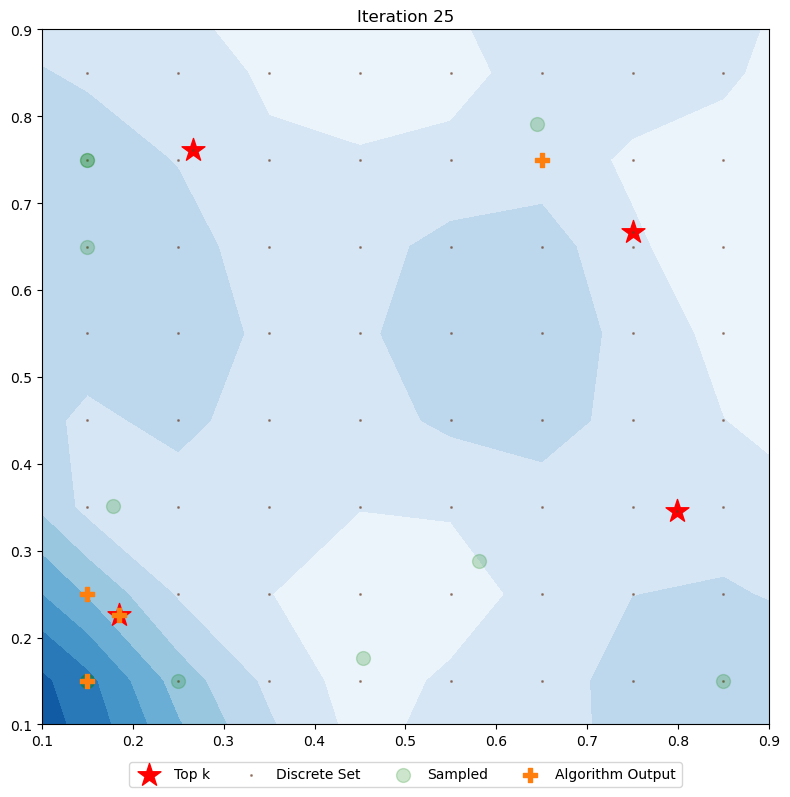

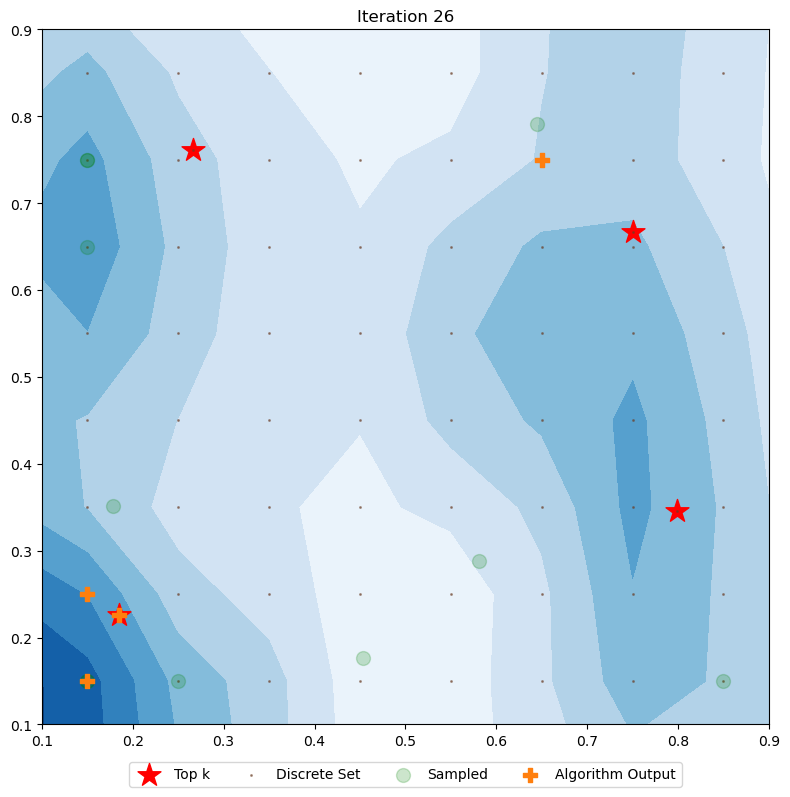

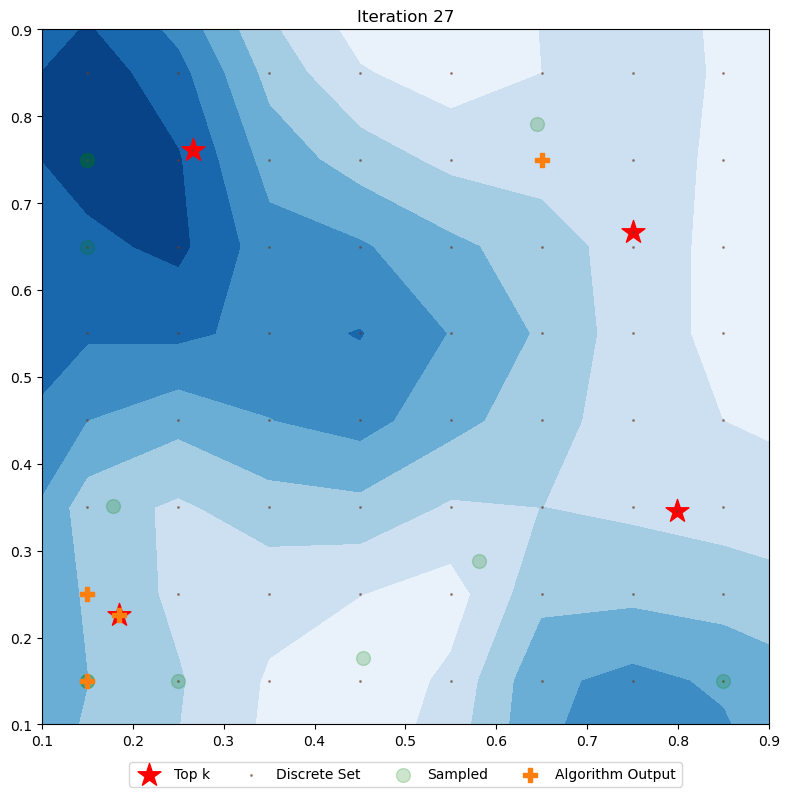

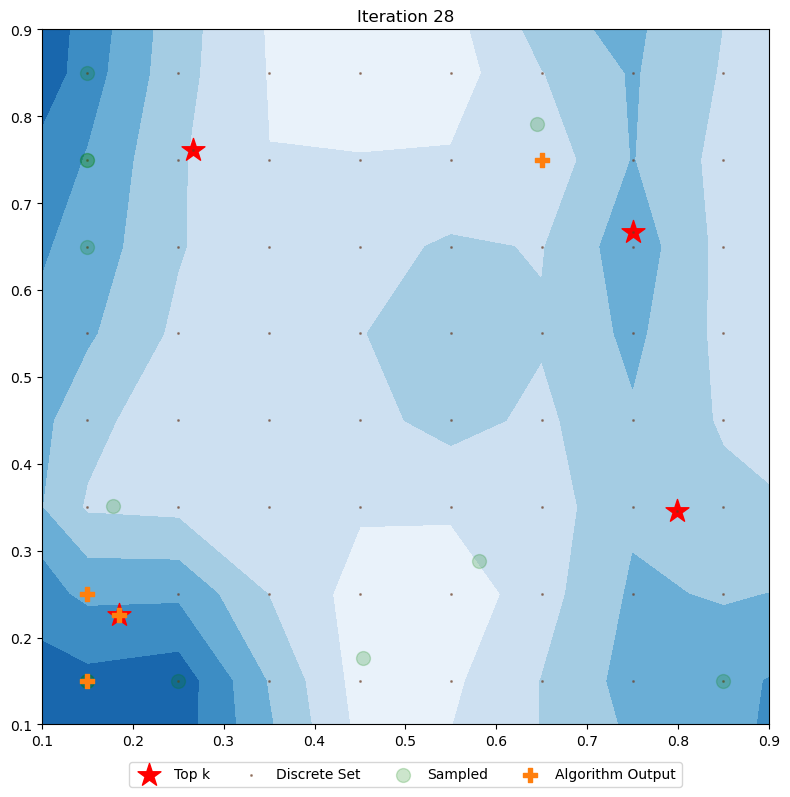

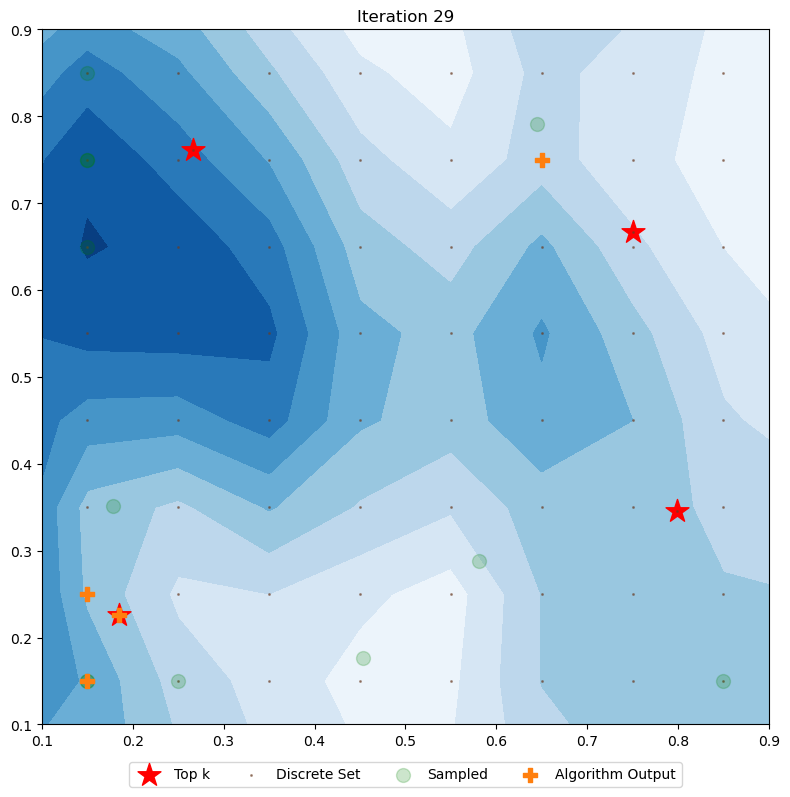

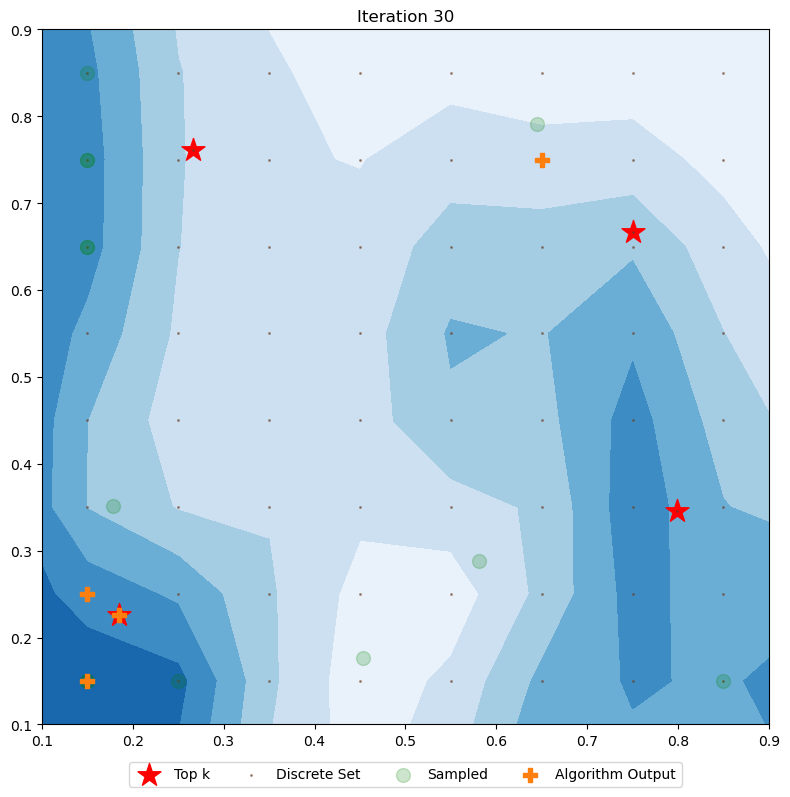

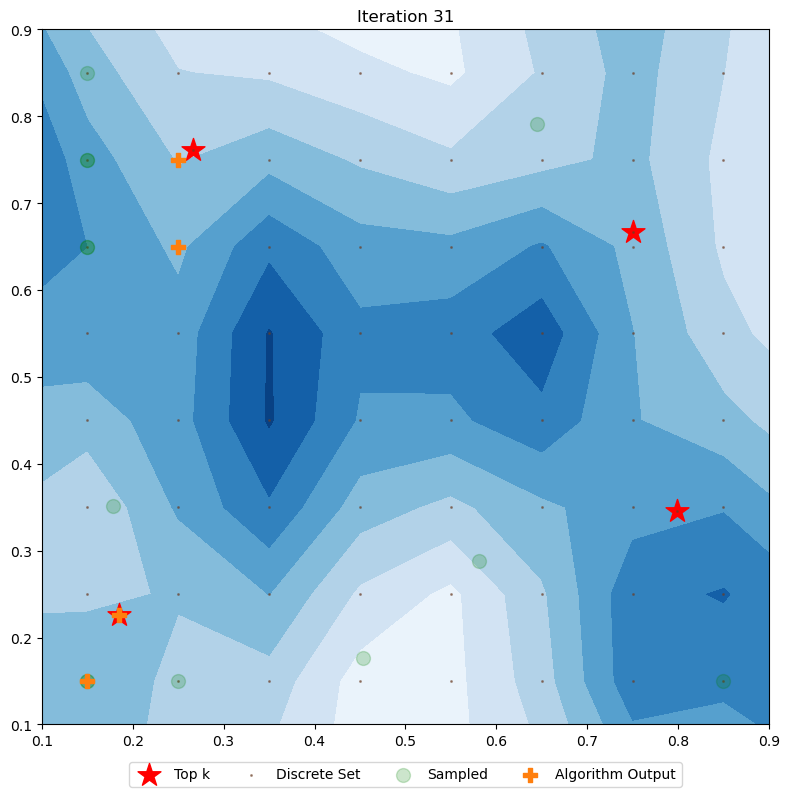

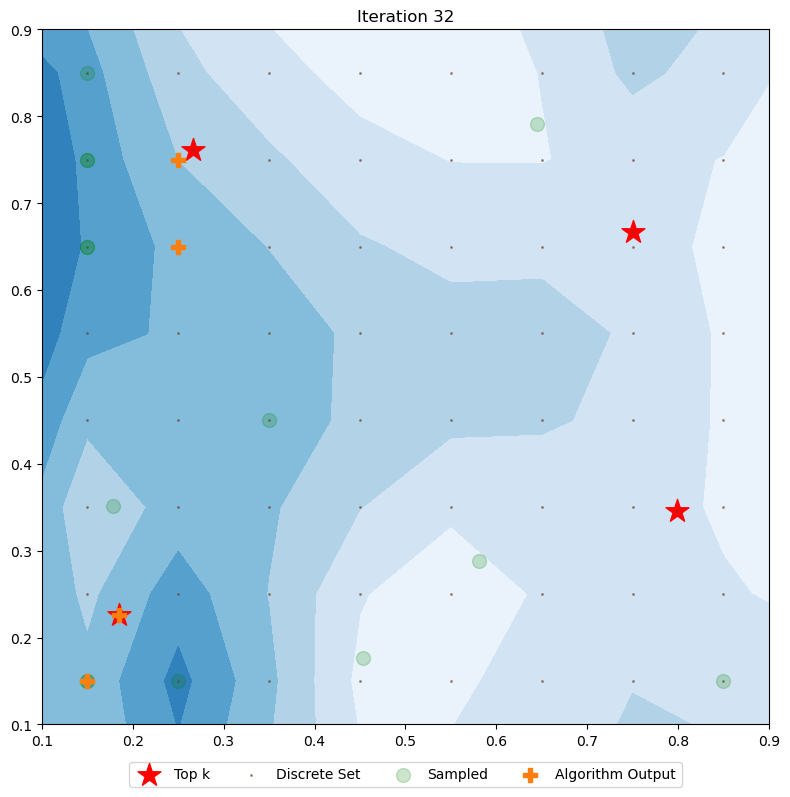

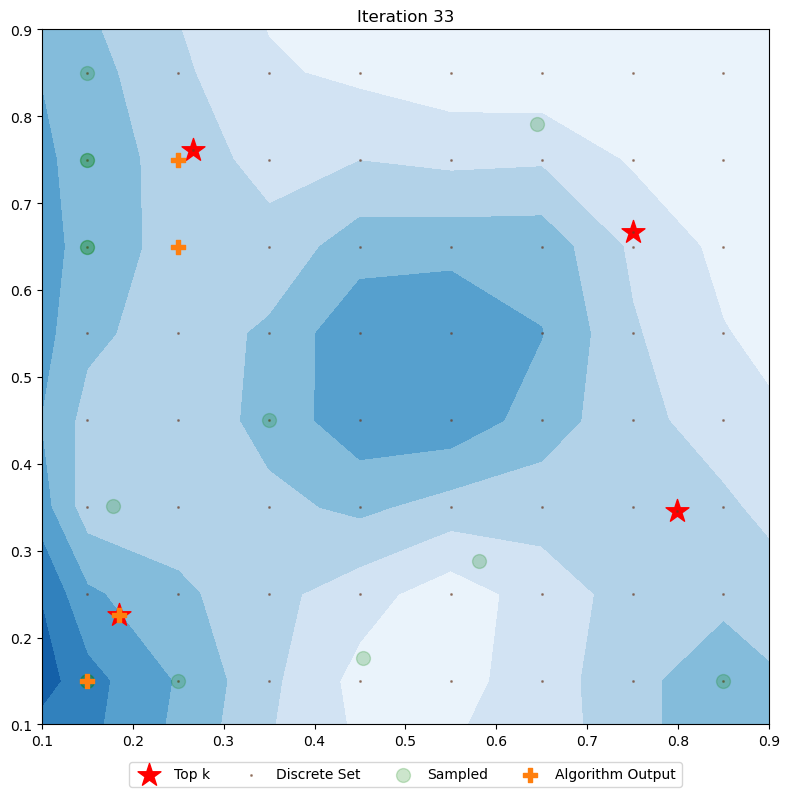

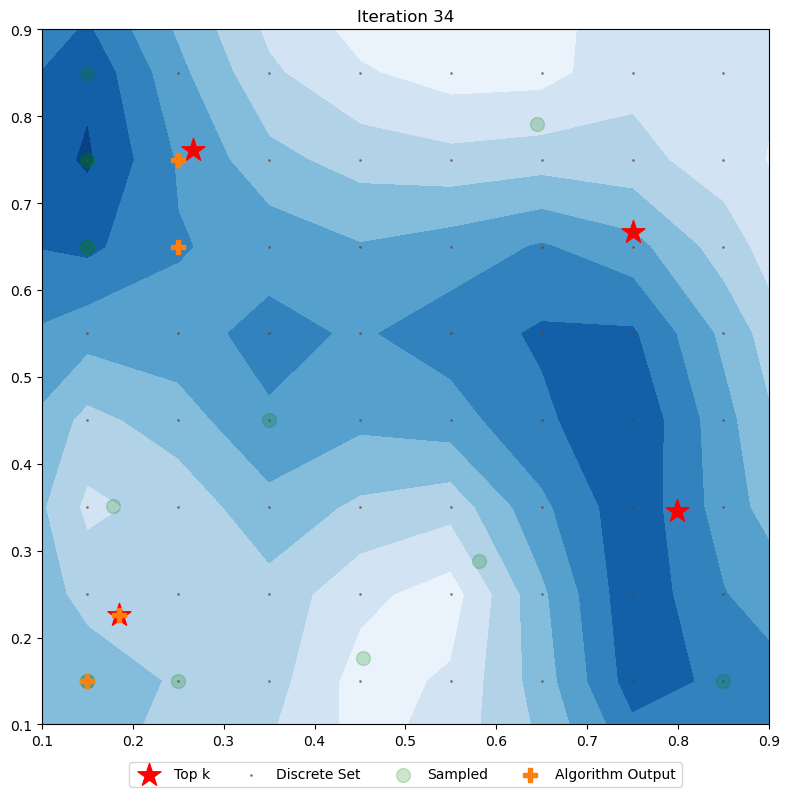

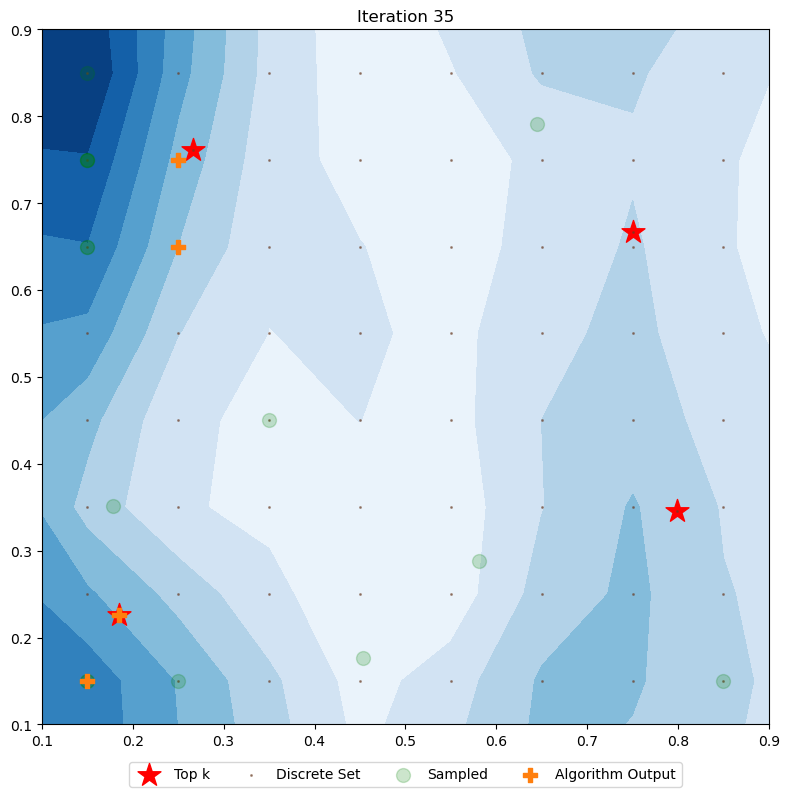

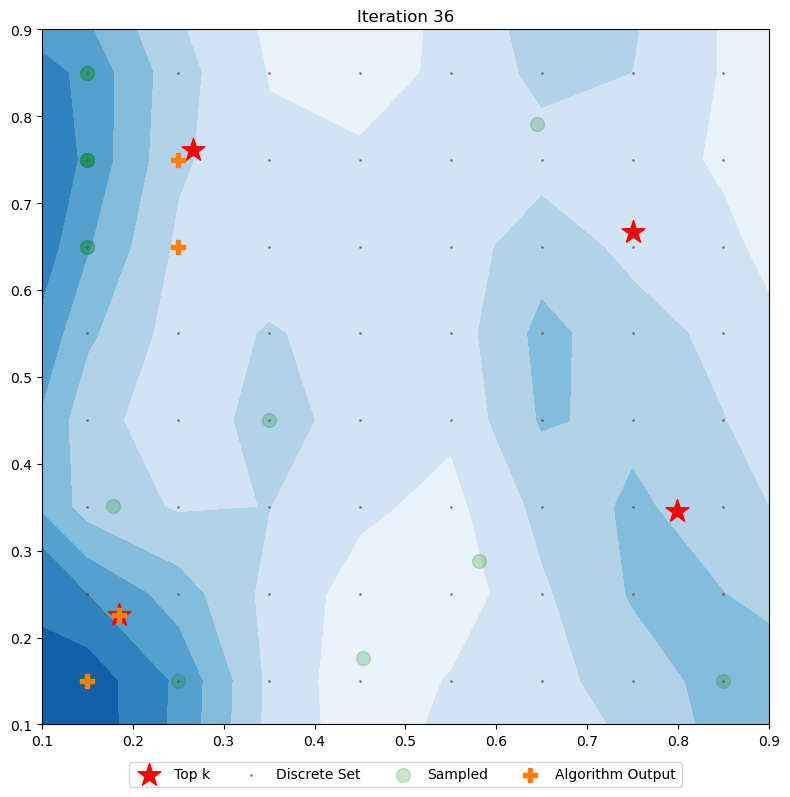

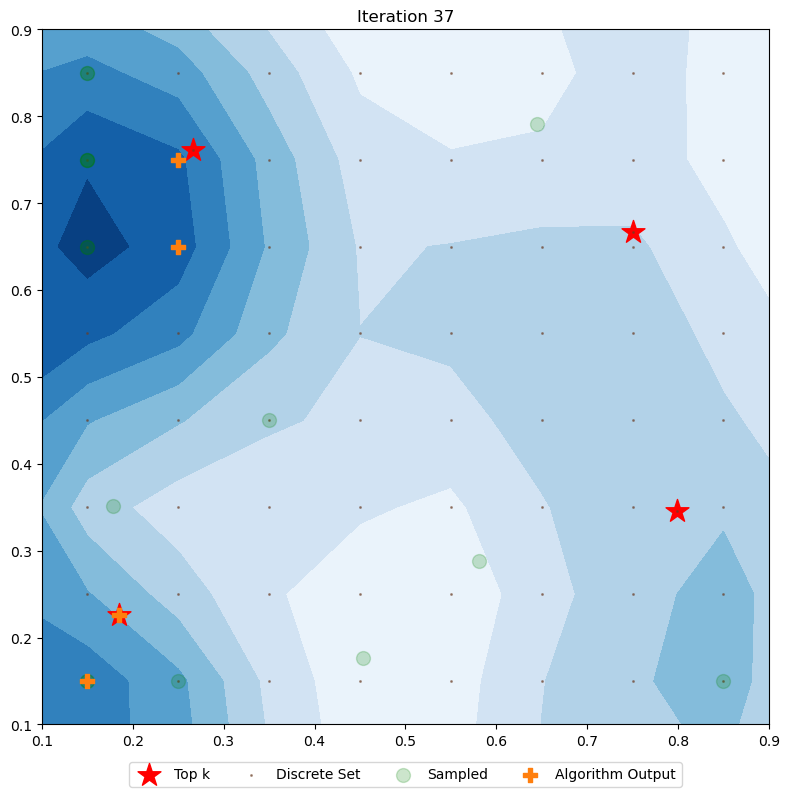

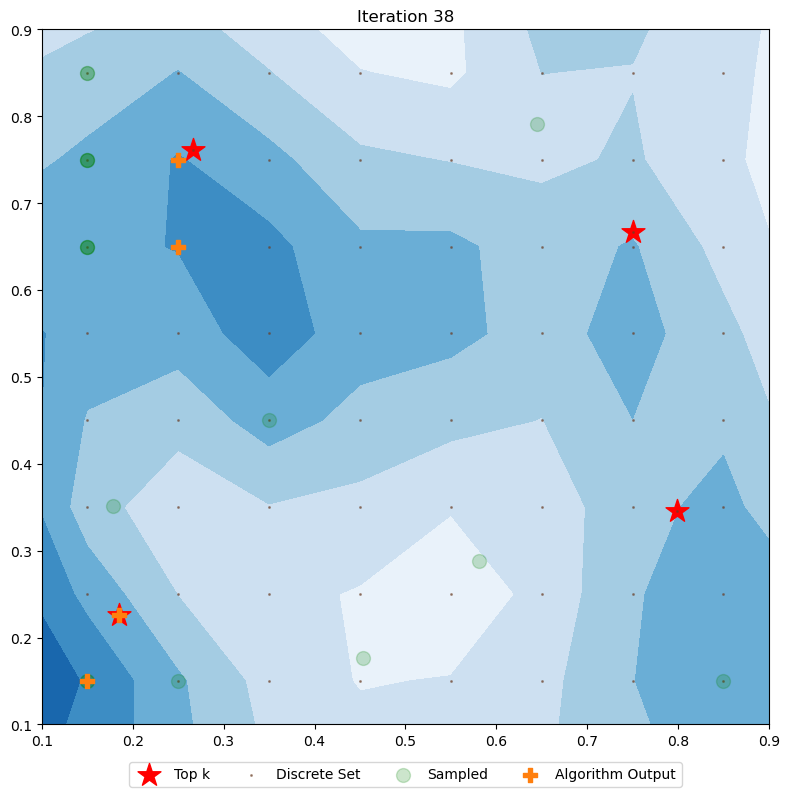

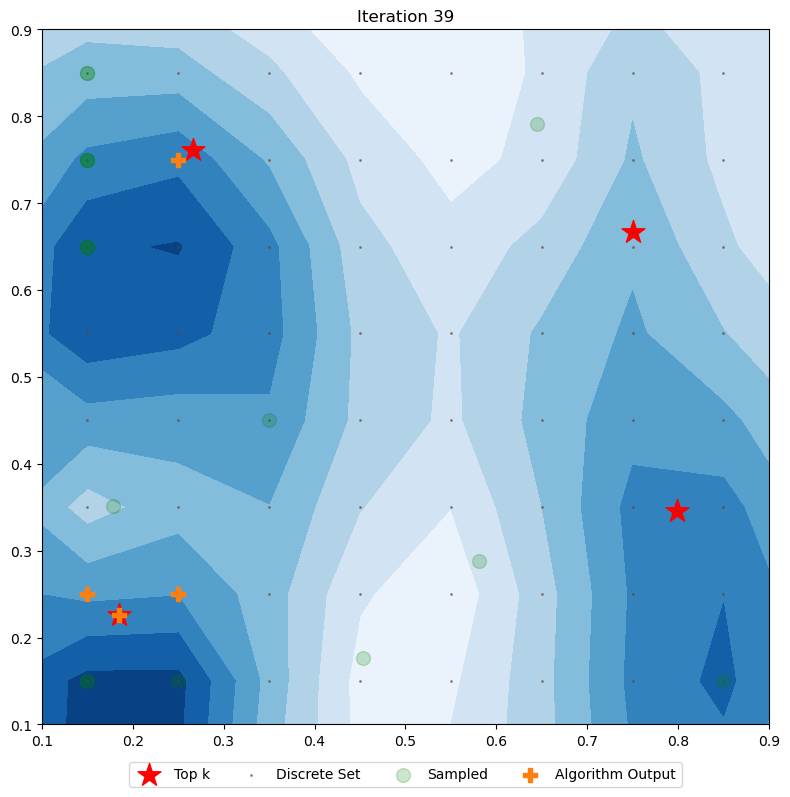

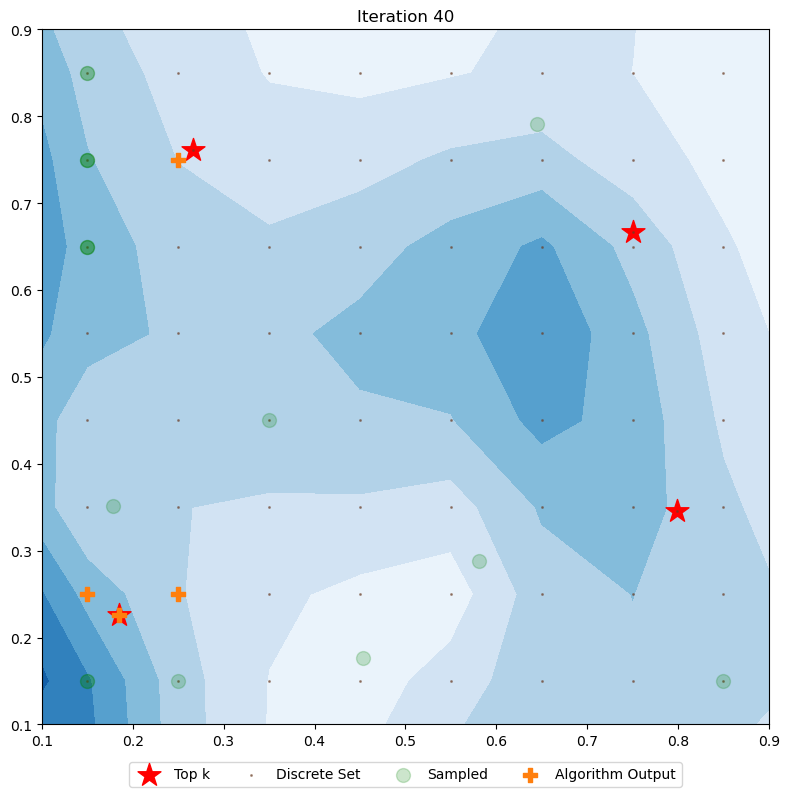

In [103]:
for i in range(max_iter):
    # plot("ps", PATH_ps)
    plot("bax", PATH_bax)
    

---

In [63]:
output.x

[[0.7987048333333333, 0.3459895],
 [0.18505749999999999, 0.22640116666666665],
 [0.26624016666666667, 0.7609426666666667],
 [0.75, 0.6666666666666666]]

In [64]:
x_top_k

array([[0.79870483, 0.3459895 ],
       [0.26624017, 0.76094267],
       [0.1850575 , 0.22640117],
       [0.75      , 0.66666667]])

In [11]:
acq_vals = []
for t in range(10):
    for policy in policies:
        algo_copy = algo.get_copy()
        if policy == "ps":
            x_next = gen_posterior_sampling_batch(models[policy], algo_copy, batch_size)
        elif policy == "bax":
            acq_func = BAXAcquisitionFunction(
                model=model, 
                algo=algo_copy,
                **kwargs, 
            )
            acq_func.initialize()
            acq_vals.append(acq_func(torch.from_numpy(x_np).unsqueeze(1)).detach().numpy())
            x_next, _ = optimize_acqf_discrete(acq_function=acq_func, q=batch_size, choices=torch.from_numpy(x_np), max_batch_size=100)
            
        y_next = obj_func(x_next)
        x_gp[policy] = torch.cat([x_gp[policy], x_next], dim=0)
        y_gp[policy] = torch.cat([y_gp[policy], y_next], dim=0)
        models[policy] = fit_model(
            x_gp[policy], 
            y_gp[policy], 
            model_type="gp", 
            **kwargs
        )
        performance, output = evaluate_performance(models[policy], algo.get_copy(), output_gt, **kwargs)
        performances[policy].append(performance)
        outputs[policy] = np.concatenate((outputs[policy], np.array(output.x)), axis=0)

        print(f"Policy: {policy}, Iter: {t}, Performance: {performances[policy][-1]} \n")

Policy: bax, Iter: 0, Performance: [1.0, 0.5294940108752936] 

Policy: bax, Iter: 1, Performance: [0.8571428571428572, 0.5027153346031872] 

Policy: bax, Iter: 2, Performance: [0.8571428571428572, 0.23003559564934725] 

Policy: bax, Iter: 3, Performance: [0.8571428571428572, 0.23003559564934725] 

Policy: bax, Iter: 4, Performance: [0.8571428571428572, 0.23003559564934725] 

Policy: bax, Iter: 5, Performance: [0.8571428571428572, 0.23003559564934725] 

Policy: bax, Iter: 6, Performance: [0.8571428571428572, 0.5027153346031872] 

Policy: bax, Iter: 7, Performance: [0.8571428571428572, 0.5027153346031872] 

Policy: bax, Iter: 8, Performance: [0.8571428571428572, 0.5027153346031872] 

Policy: bax, Iter: 9, Performance: [0.8571428571428572, 0.5027153346031872] 



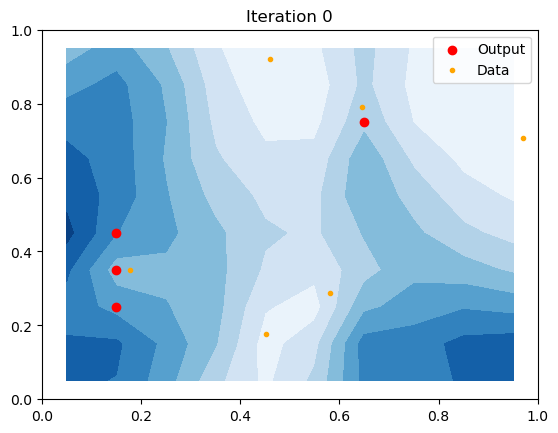

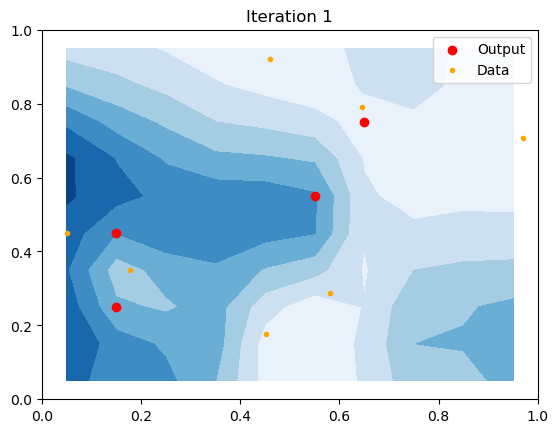

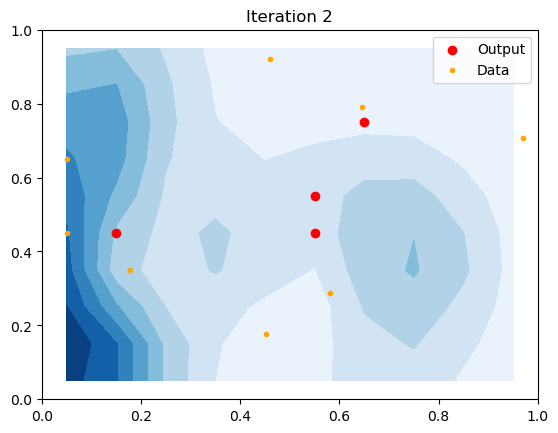

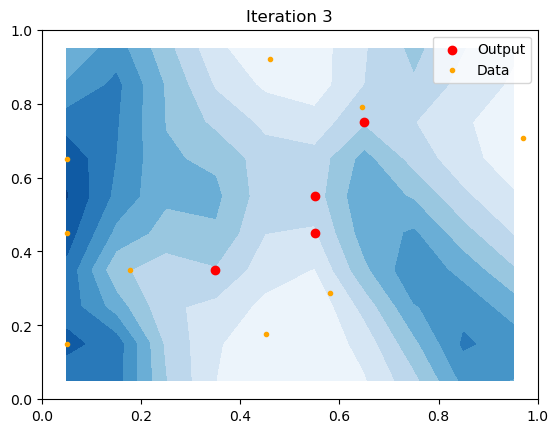

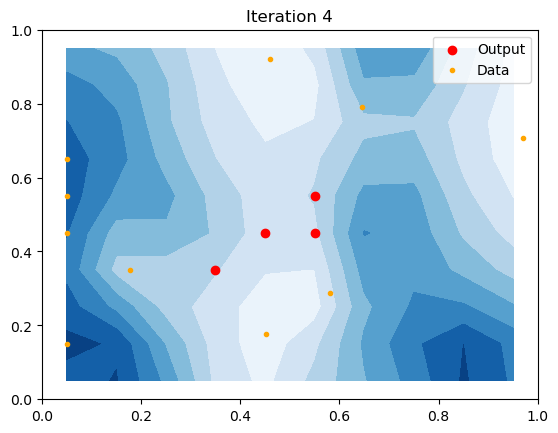

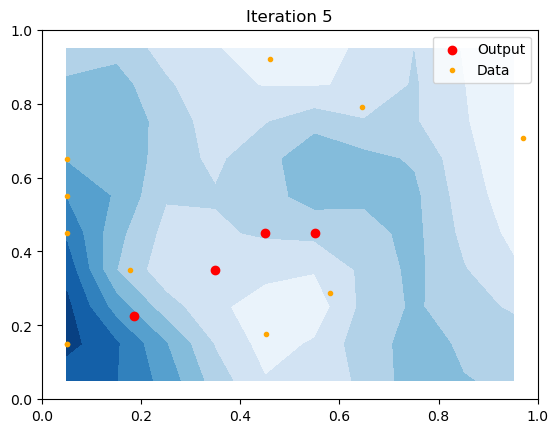

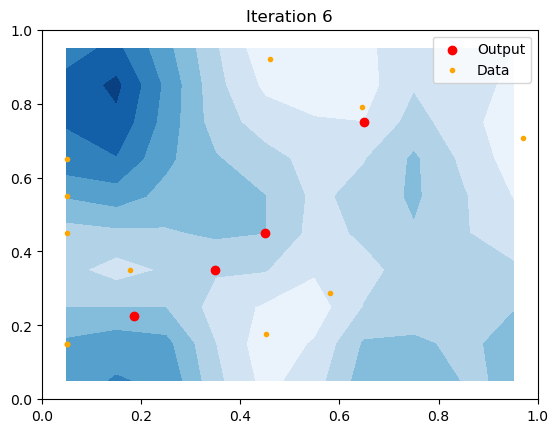

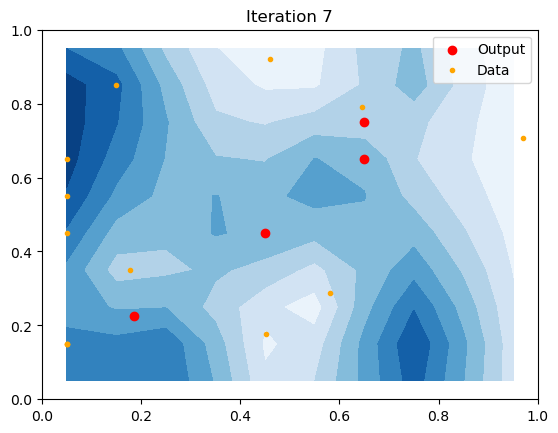

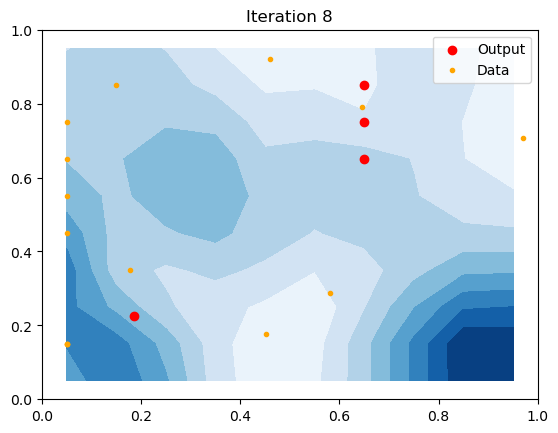

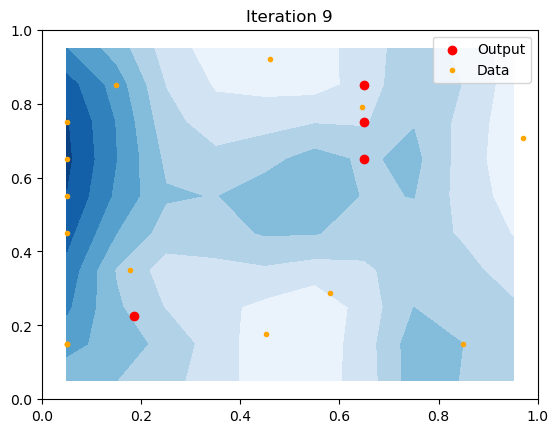

In [29]:
# plot the acq_vals for each iteration
import matplotlib.pyplot as plt
x_mesh = create_mesh(0, 1, steps=10)
for i in range(len(acq_vals)):
    acq_vals[i] = acq_vals[i][:100].reshape(10, 10)
    fig, ax = plt.subplots()
    
    
    ax.contourf(x_mesh[0], x_mesh[1], acq_vals[i], cmap="Blues")
    ax.scatter(outputs["bax"][i:i+k, 0], outputs["bax"][i:i+k, 1], c="red", label = "Output")
    ax.scatter(x_gp["bax"][:i + num_init_points, 0], x_gp["bax"][:i + num_init_points, 1], c="orange", marker=".", label = "Data")
    ax.set_title(f"Iteration {i}")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend()
    plt.show()

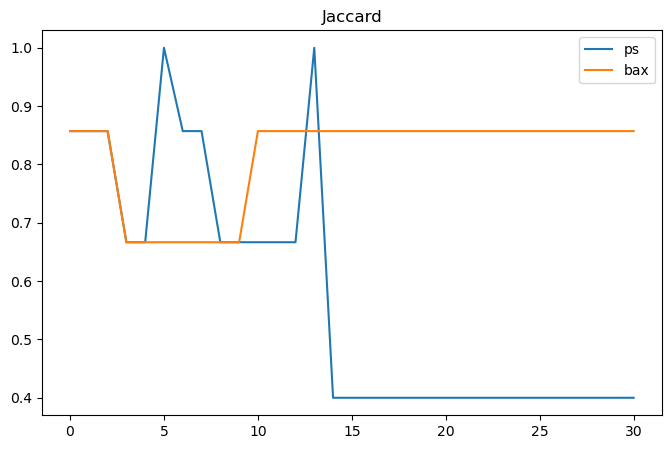

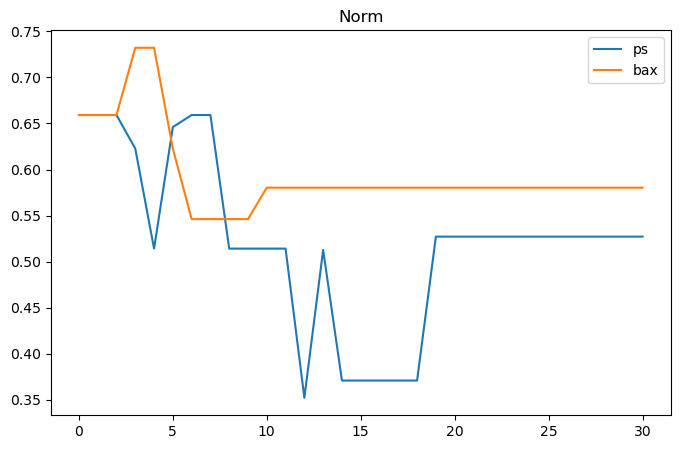

In [ ]:
# graph performance 

metrics = [
    "Jaccard",
    "Norm"
]

for policy in policies:
    performances[policy] = np.vstack(performances[policy])
for i, metric in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(8, 5))
    for policy in policies:
        ax.plot(performances[policy][:, i], label=policy)
    ax.legend()
    ax.set_title(metric)
    plt.show()

In [ ]:
for t in range(max_iter):
    for policy in policies:
        algo_copy = algo.get_copy()
        if policy == "ps":
            x_next = gen_posterior_sampling_batch(models[policy], algo_copy, batch_size)
        elif policy == "bax":
            acq_func = BAXAcquisitionFunction(
                model=model, 
                algo=algo_copy,
                **kwargs, 
            )
            acq_func.initialize()
            
            x_next, _ = optimize_acqf_discrete(acq_function=acq_func, q=batch_size, choices=torch.from_numpy(x_np), max_batch_size=100)
            
        y_next = obj_func(x_next)
        x_gp[policy] = torch.cat([x_gp[policy], x_next], dim=0)
        y_gp[policy] = torch.cat([y_gp[policy], y_next], dim=0)
        models[policy] = fit_model(
            x_gp[policy], 
            y_gp[policy], 
            model_type="gp", 
            **kwargs
        )
        performance, output = evaluate_performance(models[policy], algo.get_copy(), output_gt, **kwargs)
        performances[policy].append(performance)
        outputs[policy] = np.concatenate((outputs[policy], np.array(output.x)), axis=0)

        print(f"Policy: {policy}, Iter: {t}, Performance: {performances[policy][-1]} \n")

In [ ]:
ps_outputs = {}
n_samp = 30
for t in range(max_iter):
    x_next = gen_posterior_sampling_batch(models[policy], algo_copy, batch_size)
    y_next = obj_func(x_next)
        x_gp[policy] = torch.cat([x_gp[policy], x_next], dim=0)
        y_gp[policy] = torch.cat([y_gp[policy], y_next], dim=0)
        models[policy] = fit_model(
            x_gp[policy], 
            y_gp[policy], 
            model_type="gp", 
            **kwargs
        )
        performance, output = evaluate_performance(models[policy], algo.get_copy(), output_gt, **kwargs)
        performances[policy].append(performance)
        outputs[policy] = np.concatenate((outputs[policy], np.array(output.x)), axis=0)

        print(f"Policy: {policy}, Iter: {t}, Performance: {performances[policy][-1]} \n")
    